In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyro
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
from pyro.infer.autoguide import AutoDelta
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

from pyro.infer.autoguide import AutoDelta, AutoNormal, AutoMultivariateNormal, AutoLowRankMultivariateNormal

from pyro.infer import Predictive
import matplotlib
from varify import *
import pymc as pm
import arviz as az
import pytensor
import pytensor.tensor as pt
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

from sklearn.metrics import precision_recall_curve, auc
import numpy as np

import numpy as np    
import pandas as pd
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_curve, auc

In [41]:
df = pd.read_excel("data/brca1_findlay_2018.xlsx")

In [42]:
experiment = "X2"
experiment_df = df[df["experiment"] == experiment]
df = experiment_df.reset_index()

In [43]:
num_replicates = 2
num_variants = len(df)
num_timepoints = 2
counts = torch.zeros(torch.Size([num_replicates, num_variants, num_timepoints]))

counts[0,:,0] = torch.tensor(df['library'])
counts[1,:,0] = torch.tensor(df['library'])
counts[0,:,1] = torch.tensor(df['d11.r1'])
counts[1,:,1] = torch.tensor(df['d11.r2'])

In [44]:
num_replicates = 2
num_variants = len(df)
num_timepoints = 2

library_counts = torch.zeros(torch.Size([num_variants]))
endpoint_counts = torch.zeros(torch.Size([num_replicates, num_variants]))

library_counts = torch.tensor(df['library'])
endpoint_counts[0,:] = torch.tensor(df['d11.r1'])
endpoint_counts[1,:] = torch.tensor(df['d11.r2'])

In [45]:
RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)

# This stuff might be worthless

In [5]:
def model(library_counts, endpoint_counts, endpoint_counts_shape):
    num_replicates, num_variants = endpoint_counts_shape

    library_freq_dist = dist.Dirichlet(torch.ones(torch.Size([num_variants])), validate_args=False)
    library_freq = pyro.sample('library_freq', library_freq_dist)
    
    amplitude_dist = dist.Uniform(0, 20_000)
    library_amplitude = pyro.sample('library_amplitude', amplitude_dist)
    with pyro.plate('replicate_amplitude_plate', num_replicates, dim=-1):
        endpoint_amplitudes = pyro.sample('endpoint_amplitudes', amplitude_dist)
        
    with pyro.plate('library_counts_variant_plate', num_variants, dim=-1):
        library_counts = pyro.sample('library_counts', dist.Poisson(library_amplitude*library_freq), obs=library_counts)
    
    with pyro.plate('variant_effect_plate', num_variants):
        variant_effect = pyro.sample('variant_effect', dist.Normal(0, 10))
        
    with pyro.plate('endpoint_counts_replicates_plate', num_replicates, dim=-2) as replicate_ind:
        with pyro.plate('endpoint_counts_variant_plate', num_variants, dim=-1):
            endpoint_counts = pyro.sample('endpoint_counts', dist.Poisson((endpoint_amplitudes*(library_freq*2**(variant_effect).expand(num_replicates, num_variants)).T).T), obs=endpoint_counts)

    return variant_effect

In [6]:
num_replicates = 2
num_variants = len(df)
num_timepoints = 2

library_counts = torch.zeros(torch.Size([num_variants]))
endpoint_counts = torch.zeros(torch.Size([num_replicates, num_variants]))

library_counts = torch.tensor(df['library'])
endpoint_counts[0,:] = torch.tensor(df['d11.r1'])
endpoint_counts[1,:] = torch.tensor(df['d11.r2'])

In [7]:
guide = AutoNormal(model)

In [8]:
adam_params = {"lr": 0.05}
optimizer = Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

In [9]:
n_steps = 2_000
losses = []
pyro.clear_param_store()
for step in range(n_steps):
    loss = svi.step(library_counts, endpoint_counts, endpoint_counts.shape) / endpoint_counts.flatten().shape[0]
    if step % 100 == 0:
        print(f'step {step} out of {n_steps}; loss = {loss}')
        losses.append(loss)

step 0 out of 2000; loss = 6557.994738210661
step 100 out of 2000; loss = 1004.6385598348884
step 200 out of 2000; loss = 894.4363162198509
step 300 out of 2000; loss = 885.723419962212
step 400 out of 2000; loss = 880.2998805976449
step 500 out of 2000; loss = 877.0397075049771
step 600 out of 2000; loss = 875.8306650051321
step 700 out of 2000; loss = 875.3535215424804
step 800 out of 2000; loss = 875.164551639213
step 900 out of 2000; loss = 874.6967138243027
step 1000 out of 2000; loss = 874.4346746185269
step 1100 out of 2000; loss = 874.5861921457526
step 1200 out of 2000; loss = 874.2840776989857
step 1300 out of 2000; loss = 874.300294246238
step 1400 out of 2000; loss = 874.2572730449148
step 1500 out of 2000; loss = 874.0401377335955
step 1600 out of 2000; loss = 874.0796006247401
step 1700 out of 2000; loss = 874.1356380610512
step 1800 out of 2000; loss = 874.1657992775241
step 1900 out of 2000; loss = 874.1118052703066


In [10]:
param_store_dict = dict(pyro.get_param_store())
param_store_dict.keys()

dict_keys(['AutoNormal.locs.library_freq', 'AutoNormal.scales.library_freq', 'AutoNormal.locs.library_amplitude', 'AutoNormal.scales.library_amplitude', 'AutoNormal.locs.endpoint_amplitudes', 'AutoNormal.scales.endpoint_amplitudes', 'AutoNormal.locs.variant_effect', 'AutoNormal.scales.variant_effect'])

In [11]:
predictive = Predictive(guide, num_samples=1000)
posterior = predictive(library_counts, endpoint_counts, endpoint_counts.shape)
posterior_quantiles = {}
for key, value in posterior.items():
    posterior_quantiles[key] = torch.quantile(value, torch.tensor([0.025, 0.5, 0.975]), dim=0).detach().numpy()
posterior_quantiles.keys()

dict_keys(['library_freq_unconstrained', 'library_freq', 'library_amplitude_unconstrained', 'library_amplitude', 'endpoint_amplitudes_unconstrained', 'endpoint_amplitudes', 'variant_effect_unconstrained', 'variant_effect'])

In [12]:
colors = {
    'absent': 'b',
    'Conflicting interpretations of pathogenicity': 'y',
    'Pathogenic': 'r',
    'Likely benign': 'g',
    'Uncertain significance': 'y',
    'Benign': 'g',
    'Likely pathogenic': 'r'
}
alpha_dict = {
    'absent': 0.05,
    'Uncertain significance': 0.1,
    'Conflicting interpretations of pathogenicity': 1.0,
    'Pathogenic': 1.0,
    'Likely pathogenic': 1.0,
    'Benign': 1.0,
    'Likely benign': 1.0,

}

In [13]:
', '.join(matplotlib.style.available)

'Solarize_Light2, _classic_test_patch, _mpl-gallery, _mpl-gallery-nogrid, bmh, classic, dark_background, fast, fivethirtyeight, ggplot, grayscale, seaborn-v0_8, seaborn-v0_8-bright, seaborn-v0_8-colorblind, seaborn-v0_8-dark, seaborn-v0_8-dark-palette, seaborn-v0_8-darkgrid, seaborn-v0_8-deep, seaborn-v0_8-muted, seaborn-v0_8-notebook, seaborn-v0_8-paper, seaborn-v0_8-pastel, seaborn-v0_8-poster, seaborn-v0_8-talk, seaborn-v0_8-ticks, seaborn-v0_8-white, seaborn-v0_8-whitegrid, tableau-colorblind10'

In [14]:
matplotlib.style.use('seaborn-talk')

/tmp/ipykernel_264284/2380089948.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use('seaborn-talk')


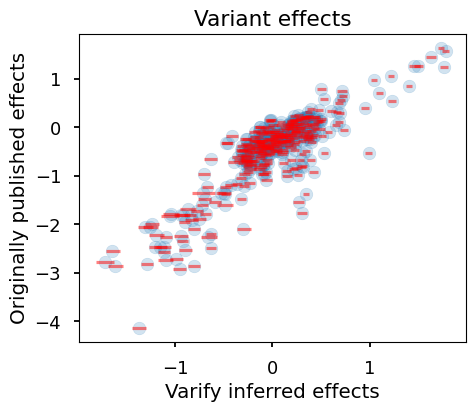

In [15]:
subsampling_level = 1
plt.figure(figsize=(5, 4))
# plt.scatter(posterior_quantiles['variant_effect'][1], (df['d11/lib.raw.r1']+df['d11/lib.raw.r2'])/2., c=df['clinvar_simple'].map(colors), alpha=df['clinvar_simple'].map(alpha_dict))
plt.scatter(posterior_quantiles['variant_effect'][1][::subsampling_level]-np.median(posterior_quantiles['variant_effect'][1][::subsampling_level]), (df['d11/lib.raw.r1']+df['d11/lib.raw.r2'])[::subsampling_level]/2., alpha=0.2)
plt.errorbar(posterior_quantiles['variant_effect'][1][::subsampling_level]-np.median(posterior_quantiles['variant_effect'][1][::subsampling_level]), (df['d11/lib.raw.r1']+df['d11/lib.raw.r2'])[::subsampling_level]/2., 
             xerr=[posterior_quantiles['variant_effect'][1][::subsampling_level]-posterior_quantiles['variant_effect'][0][::subsampling_level], posterior_quantiles['variant_effect'][2][::subsampling_level]-posterior_quantiles['variant_effect'][1][::subsampling_level]], fmt=' ', alpha=0.5, c="red")
plt.title('Variant effects')
plt.xlabel("Varify inferred effects")
_ = plt.ylabel("Originally published effects")

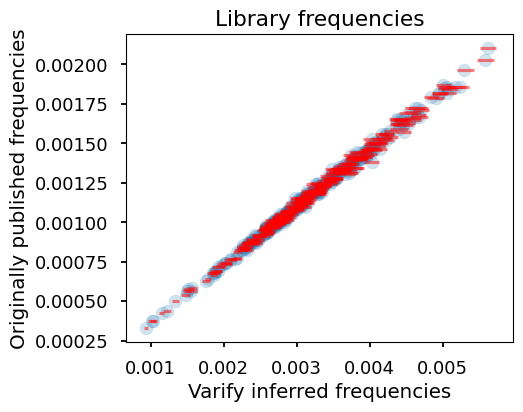

In [16]:
subsampling_level = 1
plt.figure(figsize=(5,4))
plt.scatter(posterior_quantiles['library_freq'][1][0][::subsampling_level], df['library.freq'][::subsampling_level], alpha=0.2)
plt.errorbar(posterior_quantiles['library_freq'][1][0][::subsampling_level], df['library.freq'][::subsampling_level], 
             xerr=[posterior_quantiles['library_freq'][1][0][::subsampling_level]-posterior_quantiles['library_freq'][0][0][::subsampling_level], posterior_quantiles['library_freq'][2][0][::subsampling_level]-posterior_quantiles['library_freq'][1][0][::subsampling_level]], fmt=' ', alpha=0.5, c="red")
plt.title('Library frequencies')
plt.xlabel("Varify inferred frequencies")
_ = plt.ylabel("Originally published frequencies")

In [17]:
df.columns

Index(['index', 'gene', 'chromosome', 'position (hg19)', 'reference', 'alt',
       'transcript_ID', 'transcript_position', 'transcript_ref',
       'transcript_alt', 'transcript_variant', 'aa_pos', 'aa_ref', 'aa_alt',
       'protein_variant', 'consequence', 'function.score.mean', 'func.class',
       'p.nonfunctional', 'experiment', 'negative', 'library', 'd5.r1',
       'd11.r1', 'd5.r2', 'd11.r2', 'neg.freq', 'library.freq', 'd5.freq.r1',
       'd11.freq.r1', 'd5.freq.r2', 'd11.freq.r2', 'd5/lib.ratio.r1',
       'loess.fit.r1', 'd11/lib.raw.r1', 'd11/lib.loess.r1', 'd5/lib.ratio.r2',
       'loess.fit.r2', 'd11/lib.raw.r2', 'd11/lib.loess.r2',
       'function.score.r1', 'function.score.r2', 'rna.r1', 'rna.r2',
       'rna.r1.freq', 'rna.r2.freq', 'rna.score.1', 'rna.score.2',
       'mean.rna.score', 'CADD.score', 'phyloP (mammalian)', 'polyphen2',
       'sift', 'aGVGD.diff', 'aGVGD.class', 'clinvar', 'clinvar_simple',
       'gnomAD_AF', 'bravo_AF', 'flossies_AF'],
      dtype

In [18]:
df = pd.read_excel("data/brca1_findlay_2018.xlsx", header=3)

In [19]:
matplotlib.style.use('seaborn-talk')

/tmp/ipykernel_264284/2380089948.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use('seaborn-talk')


In [20]:
x5_df = df[df['experiment'] == 'X5']

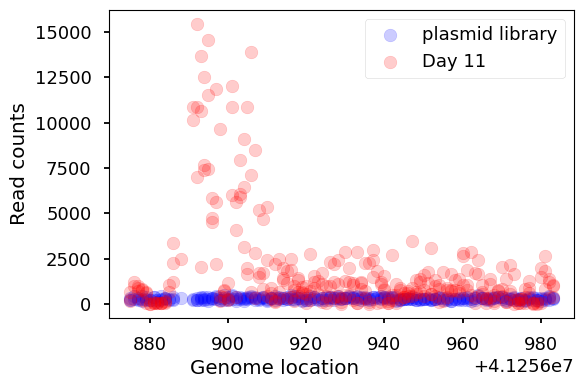

In [21]:
#fig, ax = plt.subplots(figsize=(5,4))
plt.figure(figsize=(6,4))
#df[df['experiment'] == 'X5'].plot.scatter(x='position (hg19)', y='library', ax=ax, c="blue", label='plasmid library')
plt.scatter(x5_df['position (hg19)'], x5_df['library'], c="blue", label="plasmid library", alpha=0.2)
#df[df['experiment'] == 'X5'].plot.scatter(x='position (hg19)', y='d5.r1', ax=ax, c="red")
# df[df['experiment'] == 'X5'].plot.scatter(x='position (hg19)', y='d11.r1', ax=ax, c='orange', label='Day 11')
plt.scatter(x5_df['position (hg19)'], x5_df['d11.r1'], c="red", label="Day 11", alpha=0.2)
plt.ylabel('Read counts')
plt.xlabel('Genome location                     ')
#plt.yscale('log')
plt.legend()

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


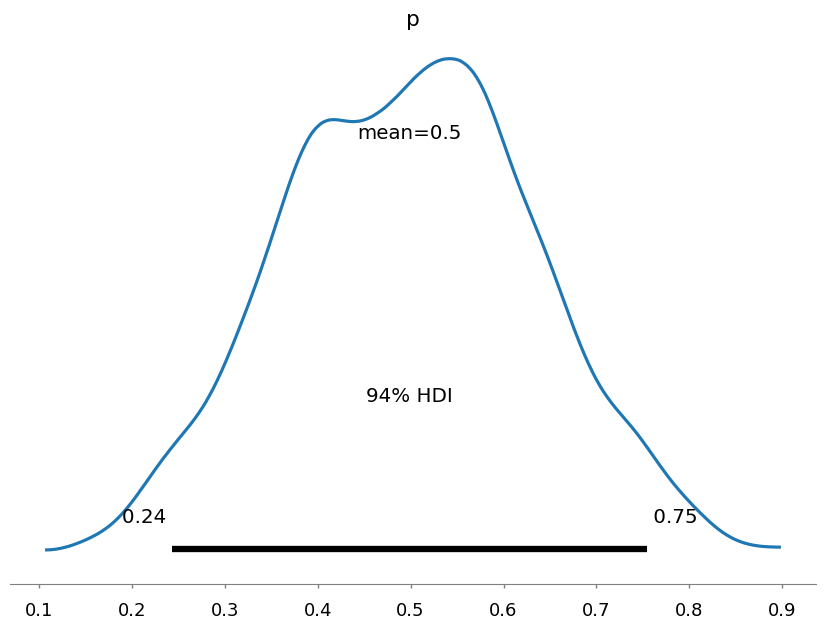

In [22]:
import pymc as pm
import arviz as az

# Assume 10 trials and 5 successes out of those trials
# Change these numbers to see how the posterior plot changes
trials = 10; successes = 5

# Set up model context
with pm.Model() as coin_flip_model:
    # Probability p of success we want to estimate
    # and assign Beta prior
    p = pm.Beta("p", alpha=1, beta=1)
    
    # Define likelihood
    obs = pm.Binomial("obs", p=p, n=trials,
        observed=successes,
    )

    # Hit Inference Button
    idata = pm.sample()


az.plot_posterior(idata, show=True);

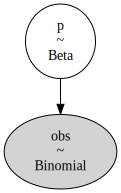

In [25]:
from pymc import model_to_graphviz
model_to_graphviz(coin_flip_model)

In [28]:
counts.size() # num_replicates, num_variants, num_timepoints

torch.Size([2, 312, 2])

In [29]:
import pytensor
import pytensor.tensor as pt
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

In [30]:
x = pt.scalar(name="x")
y = pt.vector(name="y")

print(
    f"""
x type: {x.type}
x name = {x.name}
---
y type: {y.type}
y name = {y.name}
"""
)


x type: TensorType(float64, ())
x name = x
---
y type: TensorType(float64, (?,))
y name = y



In [31]:
z = x + y
z.name = "x + y"

In [32]:
w = pt.log(z)
w.name = "log(x + y)"

In [33]:
pytensor.dprint(w)

Elemwise{log,no_inplace} [id A] 'log(x + y)'
 |Elemwise{add,no_inplace} [id B] 'x + y'
   |InplaceDimShuffle{x} [id C]
   | |x [id D]
   |y [id E]


In [34]:
f = pytensor.function(inputs=[x, y], outputs=w)

In [35]:
f(x=0, y=[1, np.e])

array([0., 1.])

In [36]:
w.eval({x: 0, y: [1, np.e]})

array([0., 1.])

In [37]:
w.eval({z: [1, np.e]})

array([0., 1.])

In [38]:
a = pt.scalar(name="a")
b = pt.scalar(name="b")

c = a / b
c.name = "a / b"

pytensor.dprint(c)

Elemwise{true_div,no_inplace} [id A] 'a / b'
 |a [id B]
 |b [id C]


In [39]:
d = b * c
d.name = "b * c"

pytensor.dprint(d)

Elemwise{mul,no_inplace} [id A] 'b * c'
 |b [id B]
 |Elemwise{true_div,no_inplace} [id C] 'a / b'
   |a [id D]
   |b [id B]


In [40]:
g = pytensor.function(inputs=[a, b], outputs=d)

pytensor.dprint(g)

DeepCopyOp [id A] 'a' 0
 |a [id B]


In [41]:
print(
    f"""
z type: {z.type}
z name = {z.name}
z owner = {z.owner}
z owner inputs = {z.owner.inputs}
z owner op = {z.owner.op}
z owner output = {z.owner.outputs}
"""
)


z type: TensorType(float64, (?,))
z name = x + y
z owner = Elemwise{add,no_inplace}(InplaceDimShuffle{x}.0, y)
z owner inputs = [InplaceDimShuffle{x}.0, y]
z owner op = Elemwise{add,no_inplace}
z owner output = [x + y]



In [42]:
# start from the top
stack = [w]

while stack:
    print("---")
    var = stack.pop(0)
    print(f"Checking variable {var} of type {var.type}")
    # check variable is not a root variable
    if var.owner is not None:
        print(f" > Op is {var.owner.op}")
        # loop over the inputs
        for i, input in enumerate(var.owner.inputs):
            print(f" > Input {i} is {input}")
            stack.append(input)
    else:
        print(f" > {var} is a root variable")

---
Checking variable log(x + y) of type TensorType(float64, (?,))
 > Op is Elemwise{log,no_inplace}
 > Input 0 is x + y
---
Checking variable x + y of type TensorType(float64, (?,))
 > Op is Elemwise{add,no_inplace}
 > Input 0 is InplaceDimShuffle{x}.0
 > Input 1 is y
---
Checking variable InplaceDimShuffle{x}.0 of type TensorType(float64, (1,))
 > Op is InplaceDimShuffle{x}
 > Input 0 is x
---
Checking variable y of type TensorType(float64, (?,))
 > y is a root variable
---
Checking variable x of type TensorType(float64, ())
 > x is a root variable


In [43]:
pytensor.dprint(w)

Elemwise{log,no_inplace} [id A] 'log(x + y)'
 |Elemwise{add,no_inplace} [id B] 'x + y'
   |InplaceDimShuffle{x} [id C]
   | |x [id D]
   |y [id E]


In [44]:
# get input tensors
list(pytensor.graph.graph_inputs(graphs=[w]))

[x, y]

In [45]:
parent_of_w = w.owner.inputs[0]  # get z tensor
new_parent_of_w = pt.exp(parent_of_w)  # modify the parent of w
new_parent_of_w.name = "exp(x + y)"

In [46]:
pytensor.dprint(w)

Elemwise{log,no_inplace} [id A] 'log(x + y)'
 |Elemwise{add,no_inplace} [id B] 'x + y'
   |InplaceDimShuffle{x} [id C]
   | |x [id D]
   |y [id E]


In [47]:
new_w = pytensor.clone_replace(output=[w], replace={parent_of_w: new_parent_of_w})[0]
new_w.name = "log(exp(x + y))"
pytensor.dprint(new_w)

Elemwise{log,no_inplace} [id A] 'log(exp(x + y))'
 |Elemwise{exp,no_inplace} [id B] 'exp(x + y)'
   |Elemwise{add,no_inplace} [id C] 'x + y'
     |InplaceDimShuffle{x} [id D]
     | |x [id E]
     |y [id F]


In [48]:
new_w.eval({x: 0, y: [1, np.e]})

array([1.        , 2.71828183])

In [49]:
f = pytensor.function(inputs=[x, y], outputs=new_w)

pytensor.dprint(f)

Elemwise{add,no_inplace} [id A] 'x + y' 1
 |InplaceDimShuffle{x} [id B] 0
 | |x [id C]
 |y [id D]


In [50]:
f(x=0, y=[1, np.e])

array([1.        , 2.71828183])

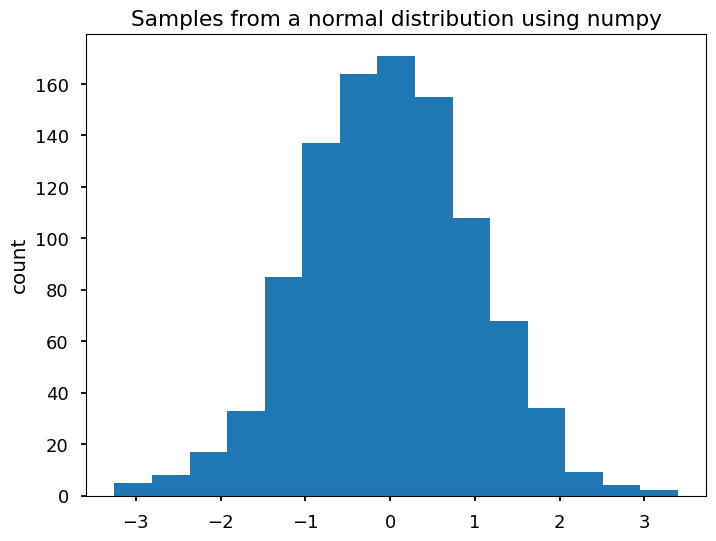

In [51]:
a = np.random.normal(loc=0, scale=1, size=1_000)

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(a, color="C0", bins=15)
ax.set(title="Samples from a normal distribution using numpy", ylabel="count");

In [52]:
y = pt.random.normal(loc=0, scale=1, name="y")
y.type

TensorType(float64, ())

In [53]:
pytensor.dprint(y)

normal_rv{0, (0, 0), floatX, False}.1 [id A] 'y'
 |RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7F5DC8879E00>) [id B]
 |TensorConstant{[]} [id C]
 |TensorConstant{11} [id D]
 |TensorConstant{0} [id E]
 |TensorConstant{1} [id F]


In [54]:
y.eval()

array(0.22965019)

In [55]:
for i in range(10):
    print(f"Sample {i}: {y.eval()}")

Sample 0: 0.22965018856966588
Sample 1: 0.22965018856966588
Sample 2: 0.22965018856966588
Sample 3: 0.22965018856966588
Sample 4: 0.22965018856966588
Sample 5: 0.22965018856966588
Sample 6: 0.22965018856966588
Sample 7: 0.22965018856966588
Sample 8: 0.22965018856966588
Sample 9: 0.22965018856966588


In [56]:
x = pm.Normal.dist(mu=0, sigma=1)
pytensor.dprint(x)

normal_rv{0, (0, 0), floatX, False}.1 [id A]
 |RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7F5DC8879000>) [id B]
 |TensorConstant{[]} [id C]
 |TensorConstant{11} [id D]
 |TensorConstant{0} [id E]
 |TensorConstant{1.0} [id F]


In [57]:
for i in range(10):
    print(f"Sample {i}: {x.eval()}")

Sample 0: -0.6546853133258914
Sample 1: -0.6546853133258914
Sample 2: -0.6546853133258914
Sample 3: -0.6546853133258914
Sample 4: -0.6546853133258914
Sample 5: -0.6546853133258914
Sample 6: -0.6546853133258914
Sample 7: -0.6546853133258914
Sample 8: -0.6546853133258914
Sample 9: -0.6546853133258914


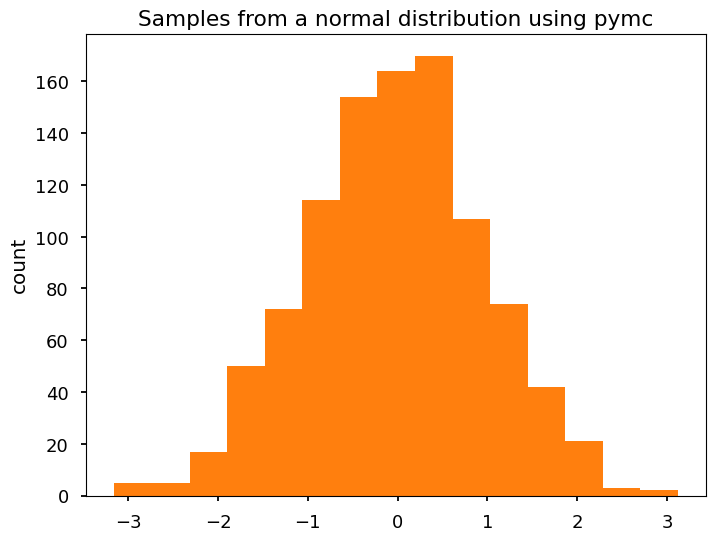

In [58]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(pm.draw(x, draws=1_000), color="C1", bins=15)
ax.set(title="Samples from a normal distribution using pymc", ylabel="count");

In [59]:
with pm.Model() as model:
    z = pm.Normal(name="z", mu=np.array([0, 0]), sigma=np.array([1, 2]))

pytensor.dprint(z)

normal_rv{0, (0, 0), floatX, False}.1 [id A] 'z'
 |RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7F5DC896B920>) [id B]
 |TensorConstant{[]} [id C]
 |TensorConstant{11} [id D]
 |TensorConstant{(2,) of 0} [id E]
 |TensorConstant{[1. 2.]} [id F]


In [60]:
model.basic_RVs

[z]

In [61]:
pytensor.dprint(model.basic_RVs[0])

normal_rv{0, (0, 0), floatX, False}.1 [id A] 'z'
 |RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7F5DC896B920>) [id B]
 |TensorConstant{[]} [id C]
 |TensorConstant{11} [id D]
 |TensorConstant{(2,) of 0} [id E]
 |TensorConstant{[1. 2.]} [id F]


In [62]:
for i in range(10):
    print(f"Sample {i}: {z.eval()}")

Sample 0: [-1.75205124 -0.00989024]
Sample 1: [-1.75205124 -0.00989024]
Sample 2: [-1.75205124 -0.00989024]
Sample 3: [-1.75205124 -0.00989024]
Sample 4: [-1.75205124 -0.00989024]
Sample 5: [-1.75205124 -0.00989024]
Sample 6: [-1.75205124 -0.00989024]
Sample 7: [-1.75205124 -0.00989024]
Sample 8: [-1.75205124 -0.00989024]
Sample 9: [-1.75205124 -0.00989024]


In [63]:
for i in range(10):
    print(f"Sample {i}: {pm.draw(z)}")

Sample 0: [-1.11836138  3.30861192]
Sample 1: [ 0.11570648 -1.08437923]
Sample 2: [1.74125638 2.16120969]
Sample 3: [2.02448716 0.54066601]
Sample 4: [ 0.77083007 -3.59543674]
Sample 5: [-0.74391589  0.47387829]
Sample 6: [ 0.38841554 -2.37214621]
Sample 7: [ 0.04194988 -1.00410624]
Sample 8: [0.975631   0.78841698]
Sample 9: [ 1.80552299 -0.37013766]


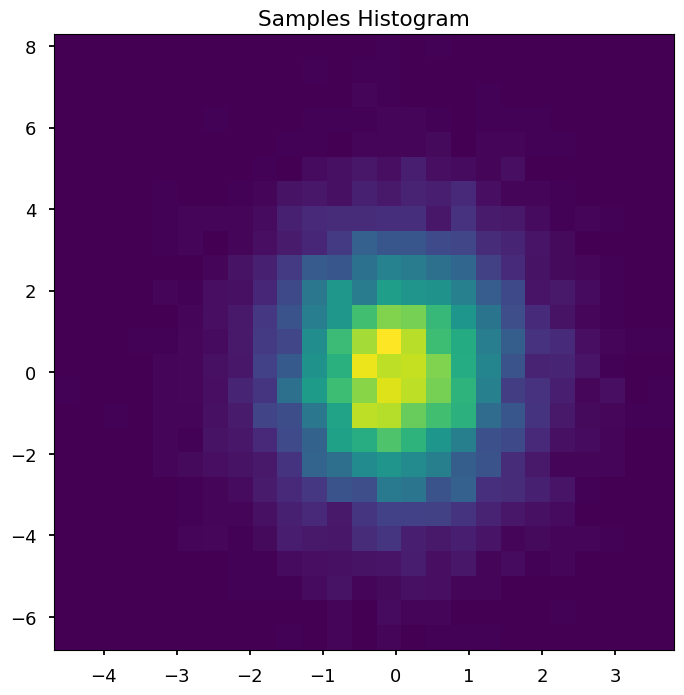

In [64]:
fig, ax = plt.subplots(figsize=(8, 8))
z_draws = pm.draw(vars=z, draws=10_000)
ax.hist2d(x=z_draws[:, 0], y=z_draws[:, 1], bins=25)
ax.set(title="Samples Histogram");

In [65]:
model

In [66]:
z_value = pt.vector(name="z")
z_logp = pm.logp(rv=z, value=z_value)

In [67]:
pytensor.dprint(z_logp)

Check{sigma > 0} [id A] 'z_logprob'
 |Elemwise{sub,no_inplace} [id B]
 | |Elemwise{sub,no_inplace} [id C]
 | | |Elemwise{mul,no_inplace} [id D]
 | | | |InplaceDimShuffle{x} [id E]
 | | | | |TensorConstant{-0.5} [id F]
 | | | |Elemwise{pow,no_inplace} [id G]
 | | |   |Elemwise{true_div,no_inplace} [id H]
 | | |   | |Elemwise{sub,no_inplace} [id I]
 | | |   | | |z [id J]
 | | |   | | |TensorConstant{(2,) of 0} [id K]
 | | |   | |TensorConstant{[1. 2.]} [id L]
 | | |   |InplaceDimShuffle{x} [id M]
 | | |     |TensorConstant{2} [id N]
 | | |InplaceDimShuffle{x} [id O]
 | |   |Elemwise{log,no_inplace} [id P]
 | |     |Elemwise{sqrt,no_inplace} [id Q]
 | |       |TensorConstant{6.283185307179586} [id R]
 | |Elemwise{log,no_inplace} [id S]
 |   |TensorConstant{[1. 2.]} [id L]
 |All [id T]
   |MakeVector{dtype='bool'} [id U]
     |All [id V]
       |Elemwise{gt,no_inplace} [id W]
         |TensorConstant{[1. 2.]} [id L]
         |InplaceDimShuffle{x} [id X]
           |TensorConstant{0} [id Y]

In [68]:
z_logp.eval({z_value: [0, 0]})

array([-0.91893853, -1.61208571])

In [69]:
scipy.stats.norm.logpdf(x=np.array([0, 0]), loc=np.array([0, 0]), scale=np.array([1, 2]))

array([-0.91893853, -1.61208571])

In [70]:
pytensor.dprint(model.logp(sum=False))

Check{sigma > 0} [id A] 'z_logprob'
 |Elemwise{sub,no_inplace} [id B]
 | |Elemwise{sub,no_inplace} [id C]
 | | |Elemwise{mul,no_inplace} [id D]
 | | | |InplaceDimShuffle{x} [id E]
 | | | | |TensorConstant{-0.5} [id F]
 | | | |Elemwise{pow,no_inplace} [id G]
 | | |   |Elemwise{true_div,no_inplace} [id H]
 | | |   | |Elemwise{sub,no_inplace} [id I]
 | | |   | | |z [id J]
 | | |   | | |TensorConstant{(2,) of 0} [id K]
 | | |   | |TensorConstant{[1. 2.]} [id L]
 | | |   |InplaceDimShuffle{x} [id M]
 | | |     |TensorConstant{2} [id N]
 | | |InplaceDimShuffle{x} [id O]
 | |   |Elemwise{log,no_inplace} [id P]
 | |     |Elemwise{sqrt,no_inplace} [id Q]
 | |       |TensorConstant{6.283185307179586} [id R]
 | |Elemwise{log,no_inplace} [id S]
 |   |TensorConstant{[1. 2.]} [id L]
 |All [id T]
   |MakeVector{dtype='bool'} [id U]
     |All [id V]
       |Elemwise{gt,no_inplace} [id W]
         |TensorConstant{[1. 2.]} [id L]
         |InplaceDimShuffle{x} [id X]
           |TensorConstant{0} [id Y]

In [71]:
logp_function = model.compile_logp(sum=False)

In [72]:
point = model.initial_point()
point

{'z': array([0., 0.])}

In [73]:
logp_function(point)

[array([-0.91893853, -1.61208571])]

In [74]:
rv = scipy.stats.norm(0, 1)

# Equivalent to rv = pm.Normal("rv", 0, 1)
scipy.stats.norm(0, 1)

In [75]:
# Equivalent to rv_draw = pm.draw(rv, 3)
rv.rvs(3)

array([-0.21191196,  0.86197983, -0.27211088])

In [76]:
# Equivalent to rv_logp = pm.logp(rv, 1.25)
rv.logpdf(1.25)

-1.7001885332046727

In [77]:
with pm.Model() as model_2:
    mu = pm.Normal(name="mu", mu=0, sigma=2)
    sigma = pm.HalfNormal(name="sigma", sigma=3)
    x = pm.Normal(name="x", mu=mu, sigma=sigma)

In [78]:
model_2.rvs_to_values

{mu: mu, sigma: sigma_log__, x: x}

In [79]:
model_2.value_vars

[mu, sigma_log__, x]

In [80]:
# extract values as pytensor.tensor.var.TensorVariable
mu_value = model_2.rvs_to_values[mu]
sigma_log_value = model_2.rvs_to_values[sigma]
x_value = model_2.rvs_to_values[x]
# element-wise log-probability of the model (we do not take te sum)
logp_graph = pt.stack(model_2.logp(sum=False))
# evaluate by passing concrete values
logp_graph.eval({mu_value: 0, sigma_log_value: -10, x_value: 0})

array([ -1.61208571, -11.32440364,   9.08106147])

In [81]:
print(
    f"""
mu_value -> {scipy.stats.norm.logpdf(x=0, loc=0, scale=2)}
sigma_log_value -> {- 10 + scipy.stats.halfnorm.logpdf(x=np.exp(-10), loc=0, scale=3)} 
x_value -> {scipy.stats.norm.logpdf(x=0, loc=0, scale=np.exp(-10))}
"""
)


mu_value -> -1.612085713764618
sigma_log_value -> -11.324403641427345 
x_value -> 9.081061466795328



In [82]:
model_2.compile_logp(sum=False)({"mu": 0, "sigma_log__": -10, "x": 0})

[array(-1.61208571), array(-11.32440364), array(9.08106147)]

In [83]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import xarray as xr

from scipy.special import expit as logistic


print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.4.0


In [84]:
az.style.use("arviz-darkgrid")

RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)


def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

In [85]:
N = 100

true_a, true_b, predictor = 0.5, 3.0, rng.normal(loc=2, scale=6, size=N)
true_mu = true_a + true_b * predictor
true_sd = 2.0

outcome = rng.normal(loc=true_mu, scale=true_sd, size=N)

f"{predictor.mean():.2f}, {predictor.std():.2f}, {outcome.mean():.2f}, {outcome.std():.2f}"

'1.59, 5.69, 4.97, 17.54'

In [86]:
predictor_scaled = standardize(predictor)
outcome_scaled = standardize(outcome)

f"{predictor_scaled.mean():.2f}, {predictor_scaled.std():.2f}, {outcome_scaled.mean():.2f}, {outcome_scaled.std():.2f}"

'0.00, 1.00, -0.00, 1.00'

In [87]:
with pm.Model() as model_1:
    a = pm.Normal("a", 0.0, 10.0)
    b = pm.Normal("b", 0.0, 10.0)

    mu = a + b * predictor_scaled
    sigma = pm.Exponential("sigma", 1.0)

    pm.Normal("obs", mu=mu, sigma=sigma, observed=outcome_scaled)
    idata = pm.sample_prior_predictive(samples=50, random_seed=rng)

Sampling: [a, b, obs, sigma]


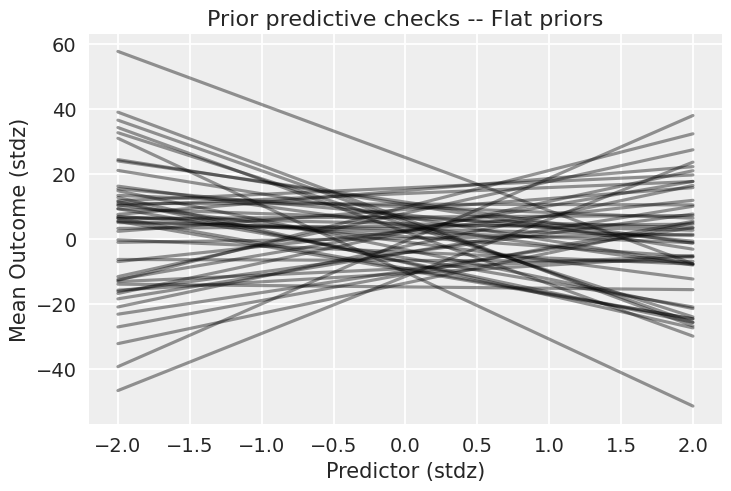

In [88]:
_, ax = plt.subplots()

x = xr.DataArray(np.linspace(-2, 2, 50), dims=["plot_dim"])
prior = idata.prior
y = prior["a"] + prior["b"] * x

ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- Flat priors");

In [89]:
with pm.Model() as model_1:
    a = pm.Normal("a", 0.0, 0.5)
    b = pm.Normal("b", 0.0, 1.0)

    mu = a + b * predictor_scaled
    sigma = pm.Exponential("sigma", 1.0)

    pm.Normal("obs", mu=mu, sigma=sigma, observed=outcome_scaled)
    idata = pm.sample_prior_predictive(samples=50, random_seed=rng)

Sampling: [a, b, obs, sigma]


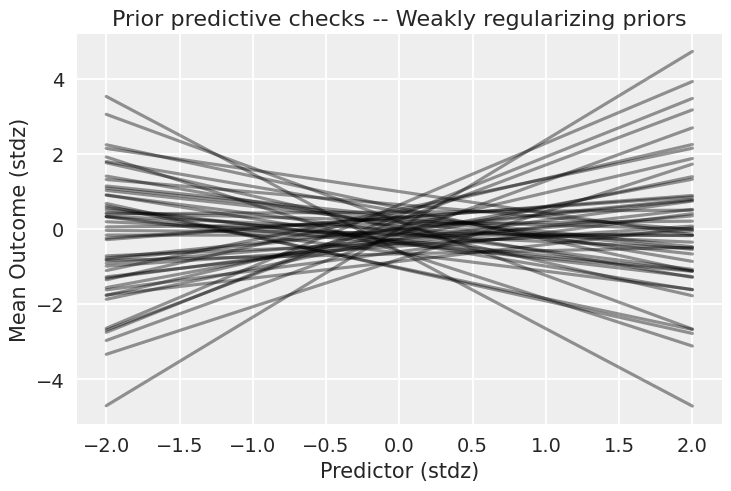

In [90]:
_, ax = plt.subplots()

x = xr.DataArray(np.linspace(-2, 2, 50), dims=["plot_dim"])
prior = idata.prior
y = prior["a"] + prior["b"] * x

ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- Weakly regularizing priors");

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.


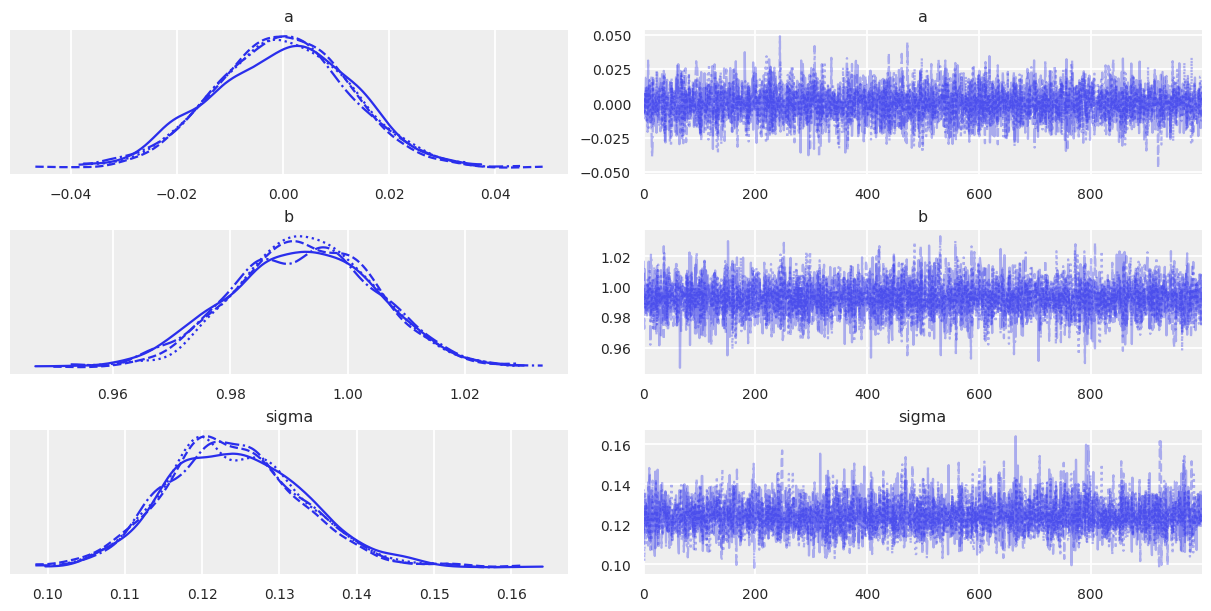

In [91]:
with model_1:
    idata.extend(pm.sample(1000, tune=2000, random_seed=rng))

az.plot_trace(idata);

In [92]:
with model_1:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng)

Sampling: [obs]


In [93]:
idata.posterior_predictive

<xarray.Dataset>
Dimensions:    (chain: 4, draw: 1000, obs_dim_2: 100)
Coordinates:
  * chain      (chain) int64 0 1 2 3
  * draw       (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * obs_dim_2  (obs_dim_2) int64 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
Data variables:
    obs        (chain, draw, obs_dim_2) float64 -0.5997 0.312 ... -0.3247 0.4695
Attributes:
    created_at:                 2023-05-27T13:22:02.460698
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.4.0

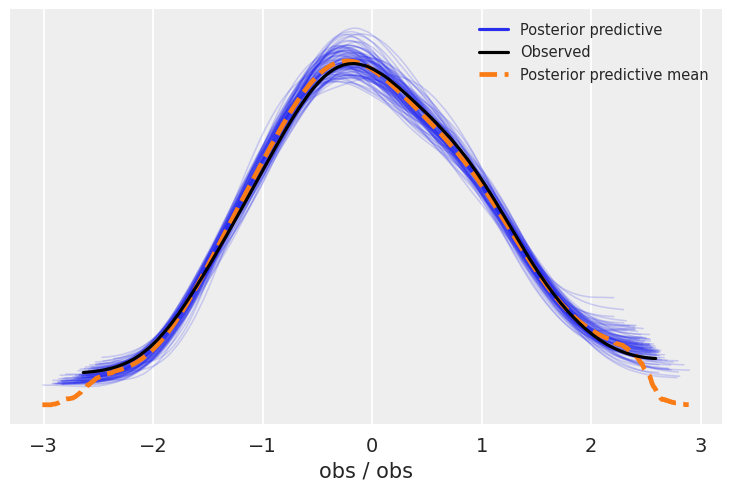

In [94]:
az.plot_ppc(idata, num_pp_samples=100);

In [95]:
post = idata.posterior
mu_pp = post["a"] + post["b"] * xr.DataArray(predictor_scaled, dims=["obs_id"])

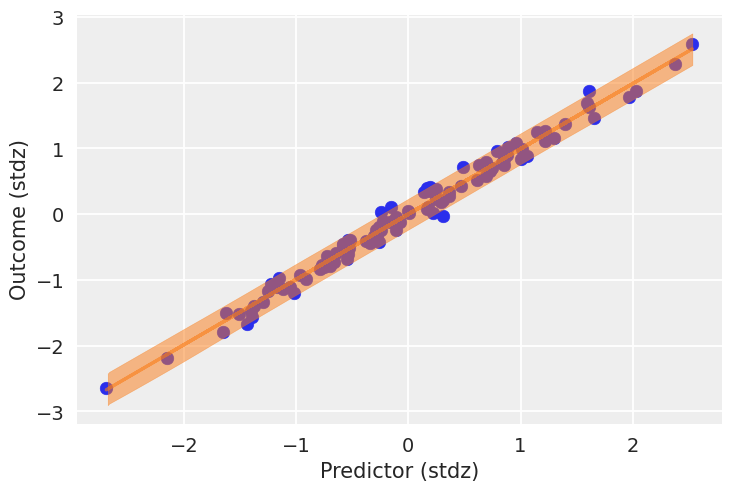

In [96]:
_, ax = plt.subplots()

ax.plot(
    predictor_scaled, mu_pp.mean(("chain", "draw")), label="Mean outcome", color="C1", alpha=0.6
)
ax.scatter(predictor_scaled, idata.observed_data["obs"])
az.plot_hdi(predictor_scaled, idata.posterior_predictive["obs"])

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Outcome (stdz)");

In [97]:
N = 400
true_intercept = 0.2
true_slope = 1.0
predictors = rng.normal(size=N)
true_p = logistic(true_intercept + true_slope * predictors)

outcomes = rng.binomial(1, true_p)
outcomes[:10]

array([1, 1, 1, 0, 1, 0, 0, 1, 1, 0])

In [98]:
with pm.Model() as model_2:
    betas = pm.Normal("betas", mu=0.0, sigma=np.array([0.5, 1.0]), shape=2)

    # set predictors as shared variable to change them for PPCs:
    pred = pm.MutableData("pred", predictors, dims="obs_id")
    p = pm.Deterministic("p", pm.math.invlogit(betas[0] + betas[1] * pred), dims="obs_id")

    outcome = pm.Bernoulli("outcome", p=p, observed=outcomes, dims="obs_id")

    idata_2 = pm.sample(1000, tune=2000, return_inferencedata=True, random_seed=rng)
az.summary(idata_2, var_names=["betas"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail   
betas[0]  0.23  0.11    0.03     0.44        0.0      0.0   3211.49   3013.30  \
betas[1]  1.03  0.13    0.78     1.29        0.0      0.0   3673.85   2720.49   

          r_hat  
betas[0]    1.0  
betas[1]    1.0

In [99]:
predictors_out_of_sample = rng.normal(size=50)
outcomes_out_of_sample = rng.binomial(
    1, logistic(true_intercept + true_slope * predictors_out_of_sample)
)

with model_2:
    # update values of predictors:
    pm.set_data({"pred": predictors_out_of_sample})
    # use the updated values and predict outcomes and probabilities:
    idata_2 = pm.sample_posterior_predictive(
        idata_2,
        var_names=["p"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=True,
        random_seed=rng,
    )

Sampling: []


In [100]:
idata_2

Inference data with groups:
	> posterior
	> predictions
	> sample_stats
	> observed_data
	> constant_data
	> predictions_constant_data

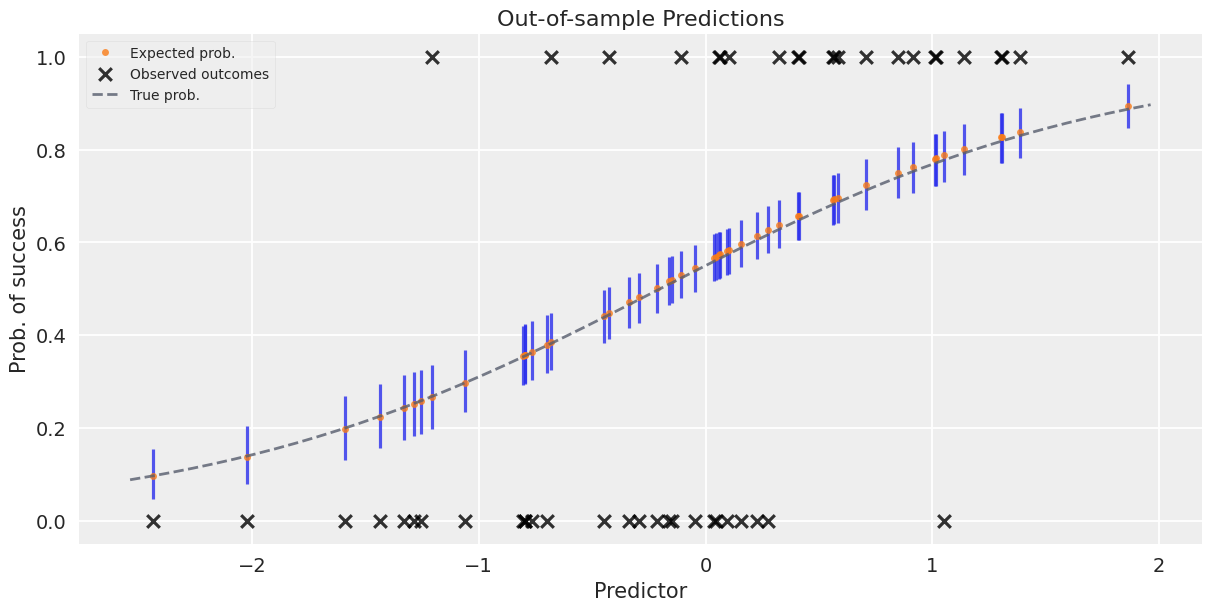

In [101]:
_, ax = plt.subplots(figsize=(12, 6))

preds_out_of_sample = idata_2.predictions_constant_data.sortby("pred")["pred"]
model_preds = idata_2.predictions.sortby(preds_out_of_sample)

# uncertainty about the estimates:
ax.vlines(
    preds_out_of_sample,
    *az.hdi(model_preds)["p"].transpose("hdi", ...),
    alpha=0.8,
)
# expected probability of success:
ax.plot(
    preds_out_of_sample,
    model_preds["p"].mean(("chain", "draw")),
    "o",
    ms=5,
    color="C1",
    alpha=0.8,
    label="Expected prob.",
)

# actual outcomes:
ax.scatter(
    x=predictors_out_of_sample,
    y=outcomes_out_of_sample,
    marker="x",
    color="k",
    alpha=0.8,
    label="Observed outcomes",
)
# true probabilities:
x = np.linspace(predictors_out_of_sample.min() - 0.1, predictors_out_of_sample.max() + 0.1)
ax.plot(
    x,
    logistic(true_intercept + true_slope * x),
    lw=2,
    ls="--",
    color="#565C6C",
    alpha=0.8,
    label="True prob.",
)

ax.set_xlabel("Predictor")
ax.set_ylabel("Prob. of success")
ax.set_title("Out-of-sample Predictions")
ax.legend(fontsize=10, frameon=True, framealpha=0.5);

In [ ]:
def model(library_counts, endpoint_counts, endpoint_counts_shape):
    num_replicates, num_variants = endpoint_counts_shape

    library_freq_dist = dist.Dirichlet(torch.ones(torch.Size([num_variants])), validate_args=False)
    library_freq = pyro.sample('library_freq', library_freq_dist)
    
    amplitude_dist = dist.Uniform(0, 20_000)
    library_amplitude = pyro.sample('library_amplitude', amplitude_dist)
    with pyro.plate('replicate_amplitude_plate', num_replicates, dim=-1):
        endpoint_amplitudes = pyro.sample('endpoint_amplitudes', amplitude_dist)
        
    with pyro.plate('library_counts_variant_plate', num_variants, dim=-1):
        library_counts = pyro.sample('library_counts', dist.Poisson(library_amplitude*library_freq), obs=library_counts)
    
    with pyro.plate('variant_effect_plate', num_variants):
        variant_effect = pyro.sample('variant_effect', dist.Normal(0, 10))
        
    with pyro.plate('endpoint_counts_replicates_plate', num_replicates, dim=-2) as replicate_ind:
        with pyro.plate('endpoint_counts_variant_plate', num_variants, dim=-1):
            endpoint_counts = pyro.sample('endpoint_counts', dist.Poisson((endpoint_amplitudes*(library_freq*2**(variant_effect).expand(num_replicates, num_variants)).T).T), obs=endpoint_counts)

    return variant_effect

In [210]:
def model(library_counts, endpoint_counts, endpoint_counts_shape):
    num_replicates, num_variants = endpoint_counts_shape

    with pm.Model() as pymc_model:
        library_freq = pm.Dirichlet('library_freq', a=np.ones((num_variants,)))

        # library_amplitude = pm.Uniform('library_amplitude', lower=95_000, upper=1_000_000)
        library_amplitude = pm.Normal('library_amplitude', mu=100_000, sigma=1_000)

        # endpoint_amplitudes = pm.Uniform('endpoint_amplitudes', lower=95_000, upper=1_000_000, shape=(num_replicates,))
        endpoint_amplitudes = pm.Normal('endpoint_amplitudes', mu=100_000, sigma=1_000, shape=(num_replicates,))

        library_counts = pm.Poisson('library_counts', mu=library_amplitude*library_freq, shape=(num_variants,), observed=library_counts)

        variant_effect = pm.Normal('variant_effect', mu=0, sigma=1, shape=(num_variants,))

        # Calculate the expected value of endpoint_counts
        # mu_endpoint_counts = (endpoint_amplitudes[:, None] * (library_freq * 2 ** variant_effect)[None, :]).T
        mu_endpoint_counts = endpoint_amplitudes[:, None] * (library_freq * pt.pow(2.0, variant_effect))[None, :]

        endpoint_counts = pm.Poisson('endpoint_counts', mu=mu_endpoint_counts, shape=(num_replicates, num_variants), observed=endpoint_counts)

    return pymc_model

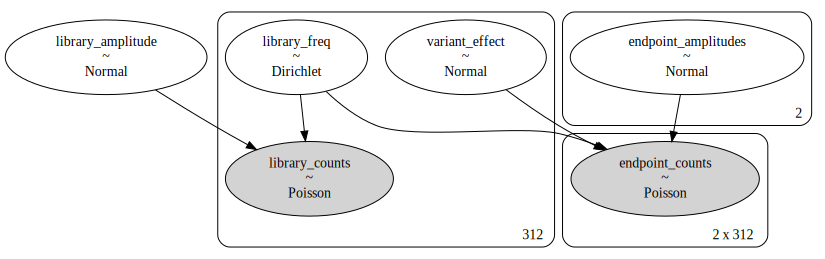

In [214]:
pm.model_to_graphviz(pymc_sge_model)

In [211]:
pymc_sge_model = model(library_counts, endpoint_counts, endpoint_counts.size())

In [212]:
with pymc_sge_model:
    idata = pm.sample_prior_predictive(samples=1_000)

Sampling: [endpoint_amplitudes, endpoint_counts, library_amplitude, library_counts, library_freq, variant_effect]


array([<Axes: xlabel='library_counts / library_counts'>,
       <Axes: xlabel='endpoint_counts / endpoint_counts'>], dtype=object)

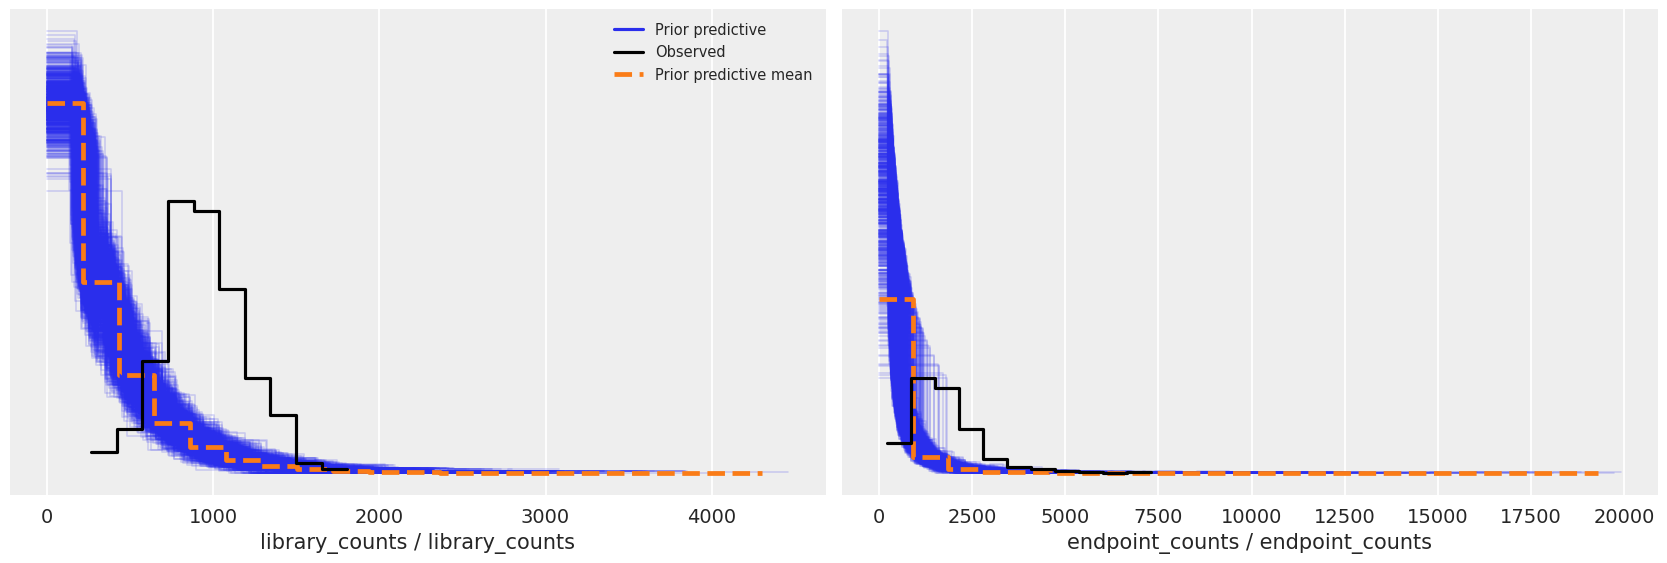

In [213]:
az.plot_ppc(idata, num_pp_samples=1_000, group='prior')

In [215]:
with pymc_sge_model:
    idata.extend(pm.sample(1000, tune=2000, random_seed=rng))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [library_freq, library_amplitude, endpoint_amplitudes, variant_effect]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 88 seconds.


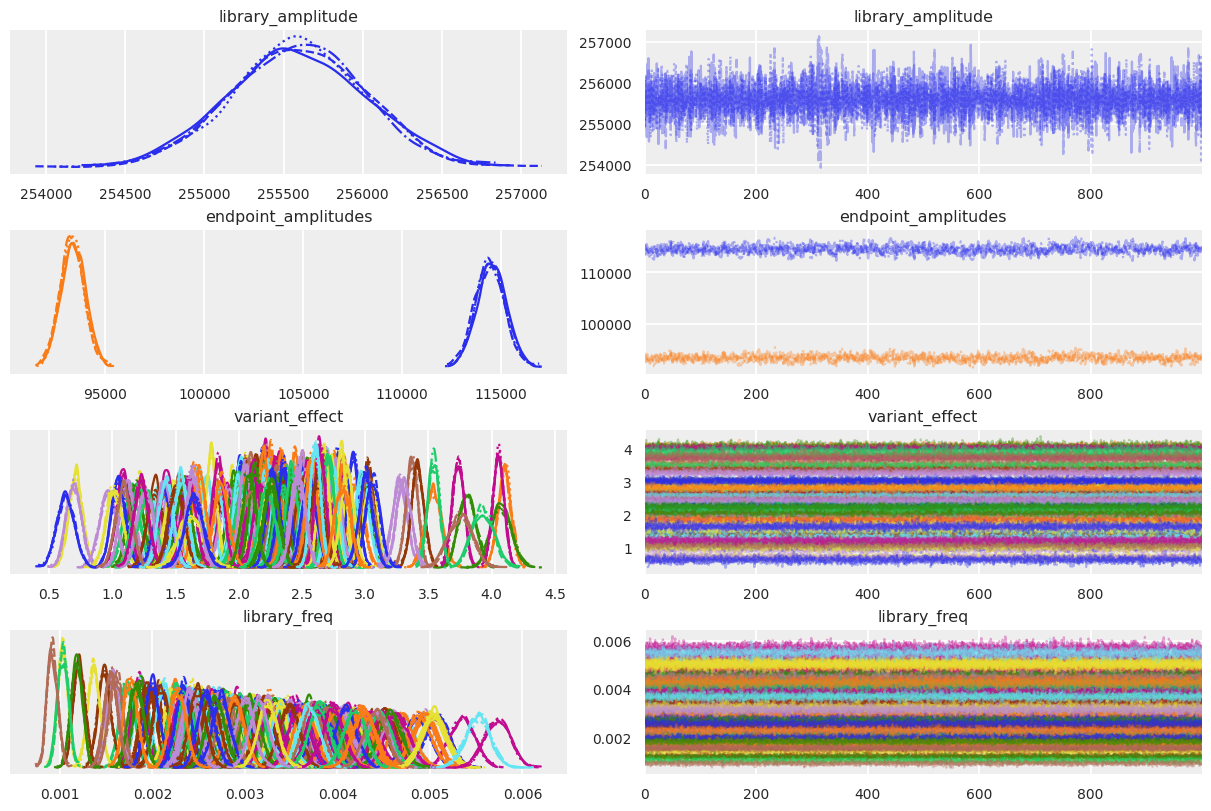

In [216]:
az.plot_trace(idata);

In [217]:
with pymc_sge_model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng)

Sampling: [endpoint_counts, library_counts]


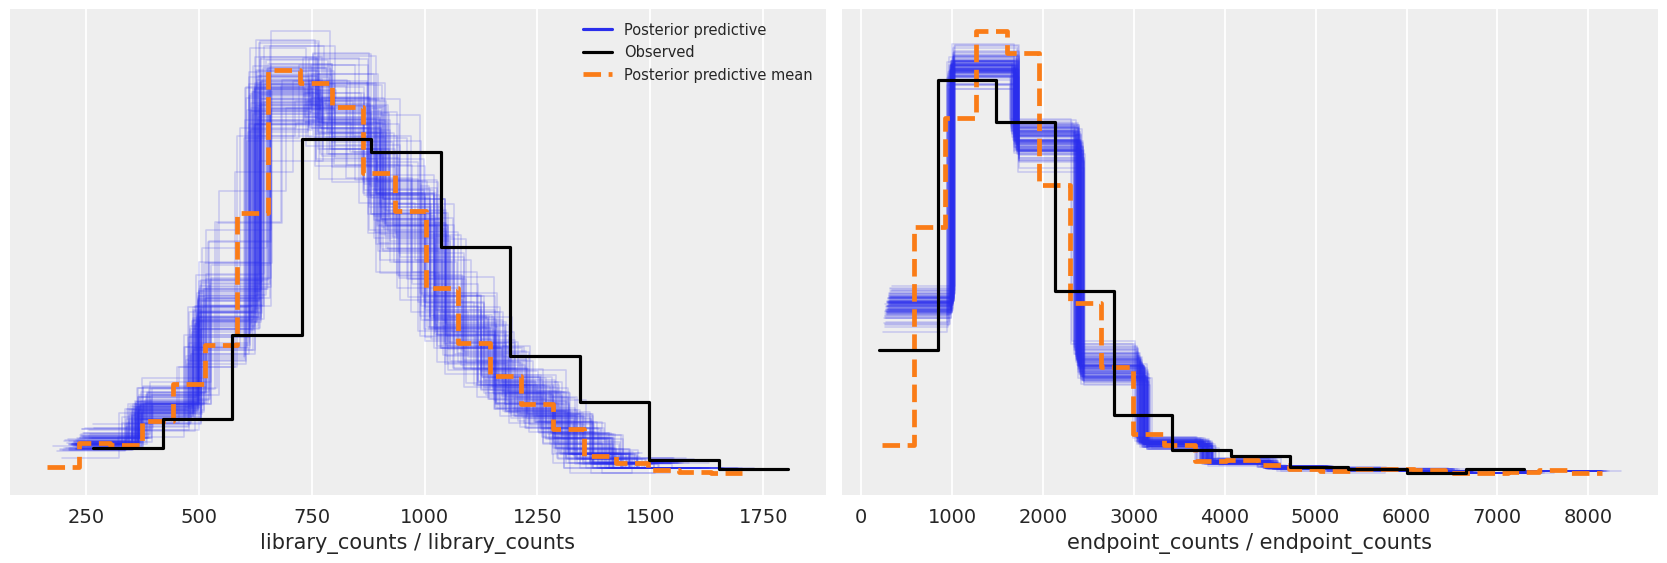

In [223]:
az.plot_ppc(idata, num_pp_samples=100, group='posterior');

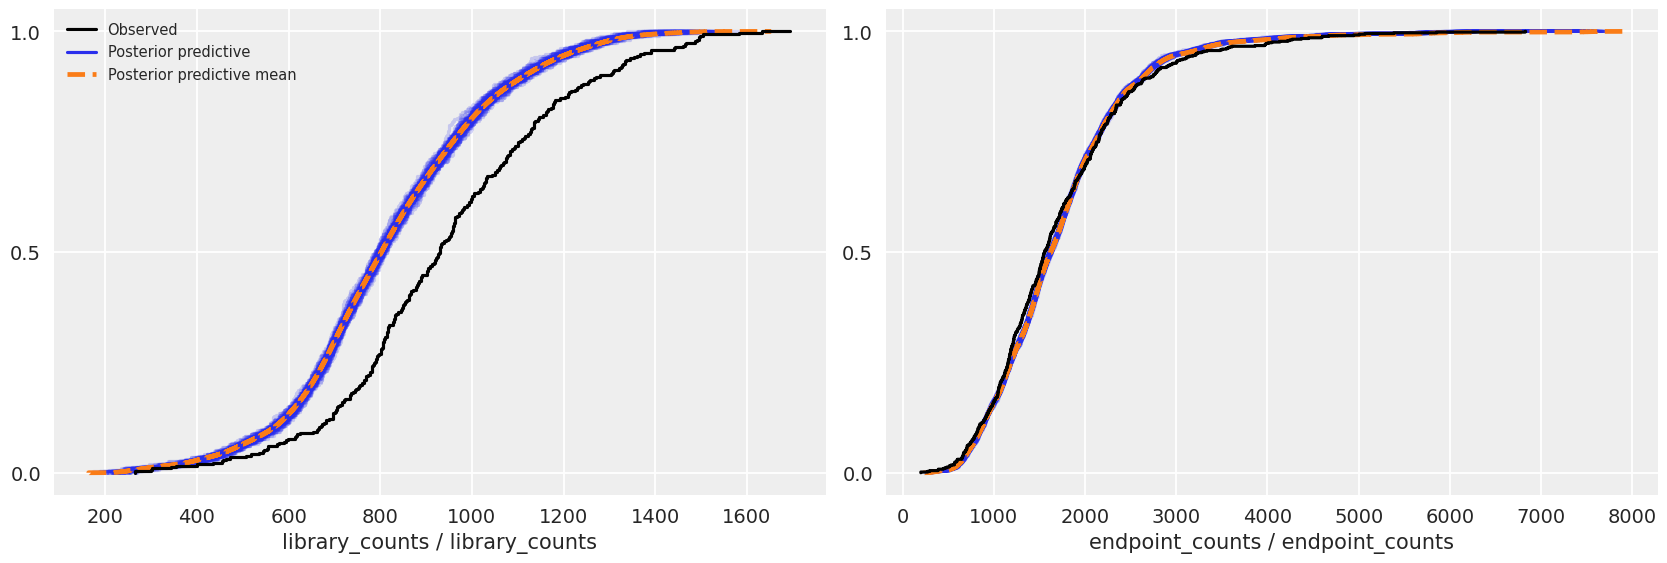

In [230]:
az.plot_ppc(idata, num_pp_samples=100, group='posterior', kind='cumulative');

# Simulate from a model with a known set of variant effects

## Draw the fixed variant effects from a normal distribution

In [237]:
endpoint_counts_shape = endpoint_counts.size()
num_replicates, num_variants = endpoint_counts_shape
variant_effect = scipy.stats.norm(loc=0, scale=1).rvs(num_variants)

## Setup a model to simulate from

In [250]:
def model(library_counts, endpoint_counts, endpoint_counts_shape, variant_effect):
    num_replicates, num_variants = endpoint_counts_shape

    with pm.Model() as pymc_model:
        library_freq = pm.Dirichlet('library_freq', a=np.ones((num_variants,)))

        # library_amplitude = pm.Uniform('library_amplitude', lower=95_000, upper=1_000_000)
        library_amplitude = pm.Normal('library_amplitude', mu=100_000, sigma=1_000)

        # endpoint_amplitudes = pm.Uniform('endpoint_amplitudes', lower=95_000, upper=1_000_000, shape=(num_replicates,))
        endpoint_amplitudes = pm.Normal('endpoint_amplitudes', mu=100_000, sigma=1_000, shape=(num_replicates,))

        library_counts = pm.Poisson('library_counts', mu=library_amplitude*library_freq, shape=(num_variants,), observed=library_counts)

        # variant_effect = pm.Normal('variant_effect', mu=0, sigma=1, shape=(num_variants,))

        # Calculate the expected value of endpoint_counts
        # mu_endpoint_counts = (endpoint_amplitudes[:, None] * (library_freq * 2 ** variant_effect)[None, :]).T
        mu_endpoint_counts = endpoint_amplitudes[:, None] * (library_freq * pt.pow(2.0, variant_effect))[None, :]

        endpoint_counts = pm.Poisson('endpoint_counts', mu=mu_endpoint_counts, shape=(num_replicates, num_variants), observed=endpoint_counts)

    return pymc_model

In [257]:
pymc_sge_model = model(library_counts, endpoint_counts, endpoint_counts.size(), variant_effect)

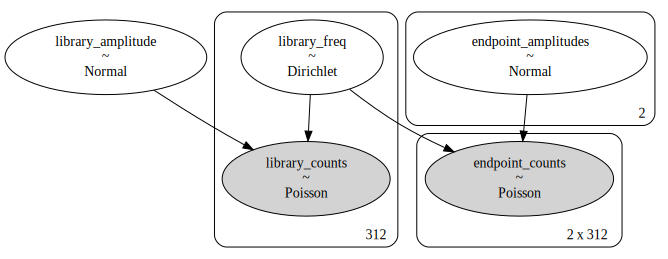

In [258]:
pm.model_to_graphviz(pymc_sge_model)

## Simulate the data by sampling from the prior predictive distribution

In [259]:
with pymc_sge_model:
    idata = pm.sample_prior_predictive(samples=1_000)

Sampling: [endpoint_amplitudes, endpoint_counts, library_amplitude, library_counts, library_freq]


## Extract the simulated counts

In [265]:
simulated_library_idata.get('prior').get('library_amplitude')

(1, 1000)

In [245]:
with pymc_sge_model:
    idata.extend(pm.sample(1000, tune=2000, random_seed=rng))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [library_freq, library_amplitude, endpoint_amplitudes]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 47 seconds.


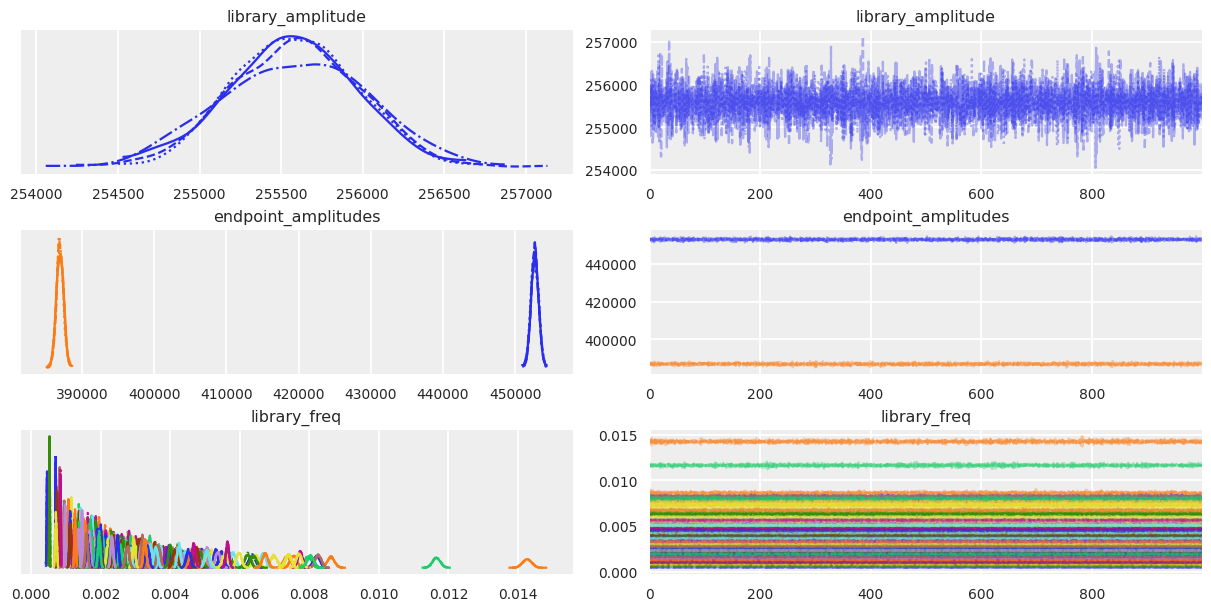

In [246]:
az.plot_trace(idata);

In [247]:
with pymc_sge_model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng)

Sampling: [endpoint_counts, library_counts]


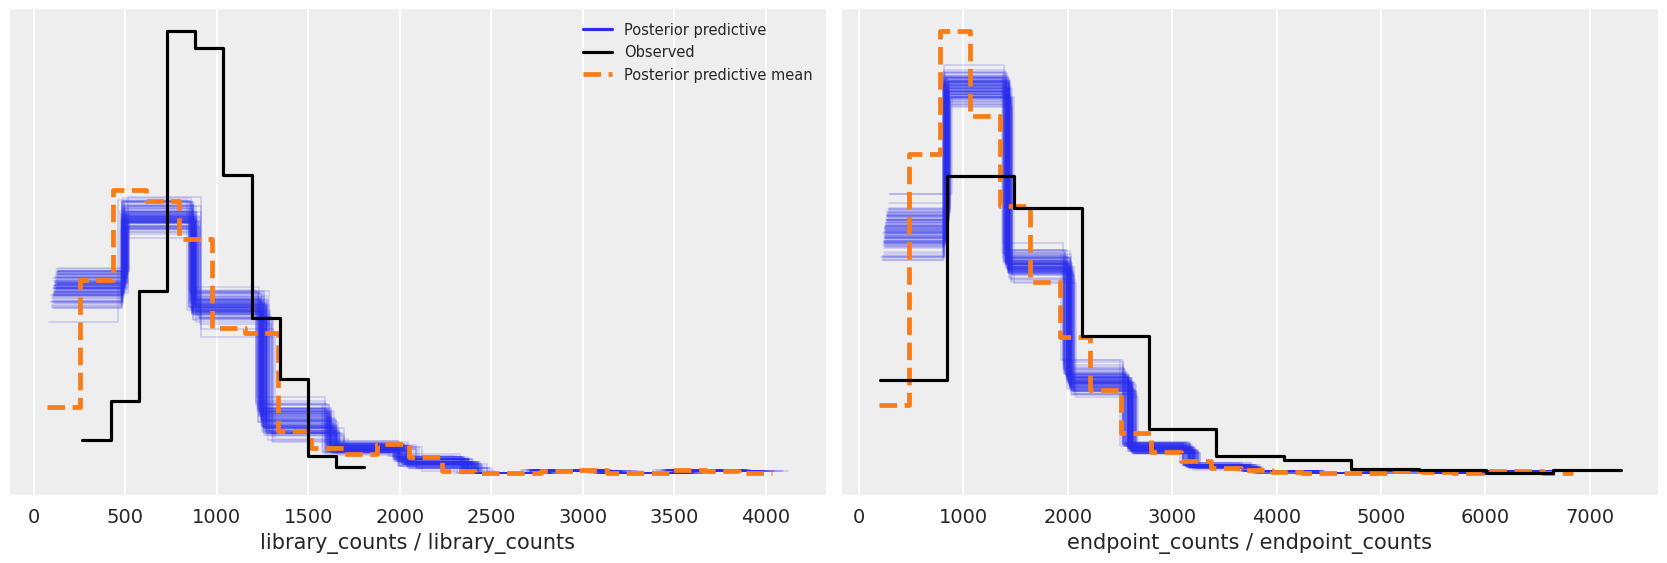

In [248]:
az.plot_ppc(idata, num_pp_samples=100, group='posterior');

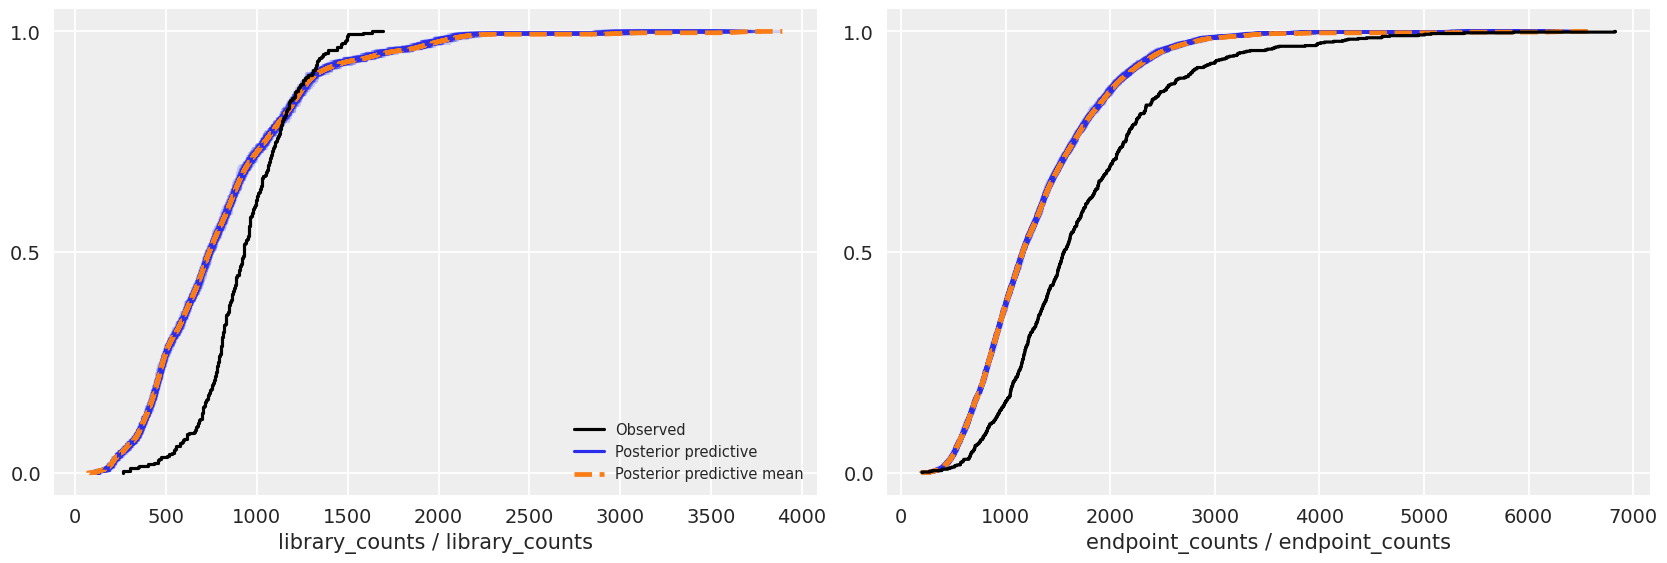

In [249]:
az.plot_ppc(idata, num_pp_samples=100, group='posterior', kind='cumulative');

In [292]:
def model(library_counts, endpoint_counts, endpoint_counts_shape):
    num_replicates, num_variants = endpoint_counts_shape

    with pm.Model() as pymc_model:
        library_freq = pm.Dirichlet('library_freq', a=np.ones((num_variants,)))

        # library_amplitude = pm.Uniform('library_amplitude', lower=95_000, upper=1_000_000)
        library_amplitude = pm.Normal('library_amplitude', mu=100_000, sigma=1_000)

        # endpoint_amplitudes = pm.Uniform('endpoint_amplitudes', lower=95_000, upper=1_000_000, shape=(num_replicates,))
        endpoint_amplitudes = pm.Normal('endpoint_amplitudes', mu=100_000, sigma=1_000, shape=(num_replicates,))

        library_counts = pm.Poisson('library_counts', mu=library_amplitude*library_freq, shape=(num_variants,), observed=library_counts)

        variant_effect = pm.Normal('variant_effect', mu=0, sigma=1, shape=(num_variants,))

        # Calculate the expected value of endpoint_counts
        # mu_endpoint_counts = (endpoint_amplitudes[:, None] * (library_freq * 2 ** variant_effect)[None, :]).T
        mu_endpoint_counts = endpoint_amplitudes[:, None] * (library_freq * pt.pow(2.0, variant_effect))[None, :]

        endpoint_counts = pm.Poisson('endpoint_counts', mu=mu_endpoint_counts, shape=(num_replicates, num_variants), observed=endpoint_counts)

    return pymc_model

In [268]:
pymc_sge_model = model(library_counts, endpoint_counts, endpoint_counts.size())

In [291]:
# pm.model_to_graphviz(pymc_sge_model)

In [288]:
# Step 1: Specify a set of known variant effects
known_variant_effects = np.random.normal(0, 1, size=num_variants)

In [272]:
# Step 2: Simulate count data from the model using these known effects
with pymc_sge_model as prior_model:
    # Fix the variant_effect to known_variant_effects
    prior_model['variant_effect'].testval = known_variant_effects
    
    # Simulate the data
    simulated_data = pm.sample_prior_predictive(samples=100, var_names=['library_counts', 'endpoint_counts'])

Sampling: [endpoint_amplitudes, endpoint_counts, library_amplitude, library_counts, library_freq, variant_effect]


In [276]:
# At this point, `simulated_data` is a dictionary with keys 'library_counts' and 'endpoint_counts'
# Each key corresponds to a 100 x num_variants or 100 x num_replicates x num_variants array of simulated count data

# Step 3: Fit the model to the simulated data
with pymc_sge_model as posterior_model:
    # Attach the simulated data to the observed variables in the model
    posterior_model['library_counts'].observed = simulated_data.get('library_counts')
    posterior_model['endpoint_counts'].observed = simulated_data.get('endpoint_counts')

    # Perform the inference
    trace = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [library_freq, library_amplitude, endpoint_amplitudes, variant_effect]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 89 seconds.


In [282]:
# Step 4: Compare the inferred effects to the known effects
# Extract the posterior samples for 'variant_effect'
inferred_variant_effects = trace.posterior.get('variant_effect')

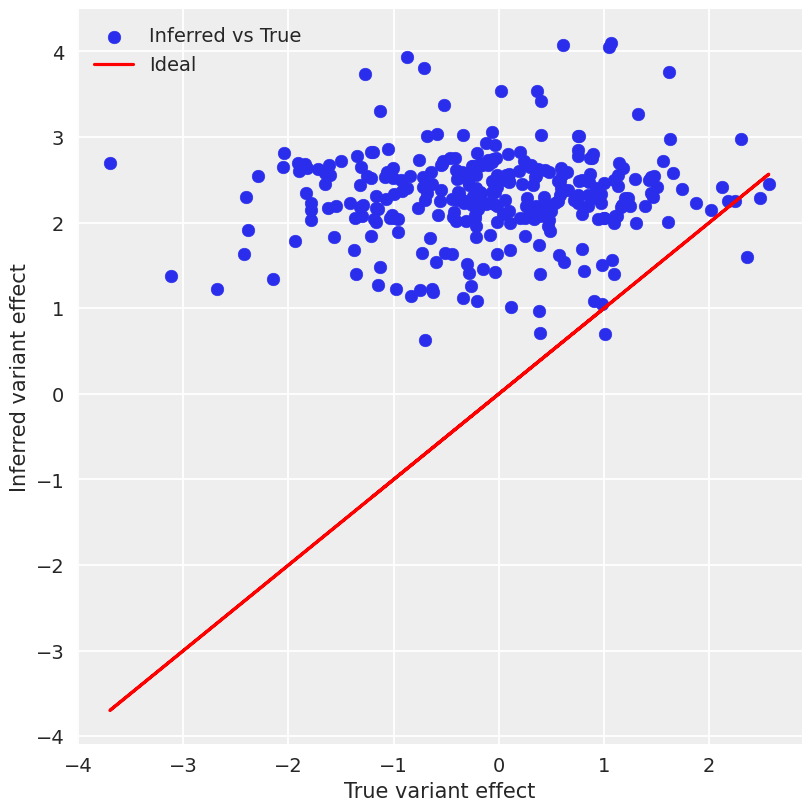

In [285]:
# Make a comparison plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.scatter(known_variant_effects, inferred_variant_effects.mean(axis=(0,1)), label='Inferred vs True')
plt.plot(known_variant_effects, known_variant_effects, color='red', label='Ideal')
plt.xlabel('True variant effect')
plt.ylabel('Inferred variant effect')
plt.legend()
plt.show()

In [286]:
inferred_variant_effects.mean(axis=(0,1))

<xarray.DataArray 'variant_effect' (variant_effect_dim_0: 312)>
array([2.05933208, 2.17644208, 2.22055384, 2.28807624, 2.0417448 ,
       2.2339373 , 1.9600403 , 2.25523485, 2.53046921, 2.67576853,
       2.01207673, 2.26139795, 1.96454728, 2.43993413, 2.27568532,
       2.18857755, 2.06419293, 2.1275727 , 2.35088241, 2.50139475,
       2.27826394, 2.33790397, 2.56629197, 2.14479445, 2.45470099,
       2.44505099, 1.68379054, 2.23412973, 2.2263703 , 2.05894975,
       2.19309301, 2.6921772 , 2.09573989, 2.0247506 , 2.05438137,
       2.00151522, 2.36427599, 2.28586927, 2.14765815, 2.04821094,
       2.09154501, 2.2103082 , 2.31134755, 2.22007416, 2.04233409,
       2.05440867, 2.0409075 , 2.22765356, 2.456725  , 2.05354059,
       2.68004915, 2.36149049, 2.25906779, 2.28900183, 2.34143567,
       2.18578894, 2.37905215, 2.72070341, 1.6366647 , 2.0811684 ,
       2.39158667, 2.37841254, 2.14009822, 2.31116644, 2.30131736,
       1.37384895, 1.23034829, 1.14828172, 1.45783923, 1.40071932,
       1.51476156, 1.21520676, 1.1849093 , 1.08501319, 2.08910917,
       1.74370235, 2.71921928, 2.45251327, 1.62877474, 1.89514628,
       2.49043572, 2.68322039, 2.54683105, 2.30458143, 2.29354033,
       2.59373086, 0.70994044, 2.5584182 , 0.96570339, 2.19319836,
       2.55337504, 2.4530511 , 2.56692207, 2.28857123, 2.53024444,
       2.19759881, 2.48716752, 2.04895603, 2.25350686, 2.65041565,
...
       2.51628702, 3.03432232, 2.75410001, 2.65396554, 2.08640383,
       2.53240623, 1.68871057, 1.56423259, 1.4344768 , 2.51235187,
       2.60100382, 2.80196744, 2.41712603, 2.50198763, 1.40321366,
       1.39777459, 2.82828519, 2.98075947, 2.54970755, 2.63867298,
       2.31843413, 2.23324617, 2.37570999, 1.41058765, 2.40308802,
       2.90452072, 2.40238742, 2.33053202, 2.65831155, 2.35920547,
       2.97571709, 2.56009548, 2.34933856, 2.75616517, 2.8100302 ,
       2.72529946, 1.85988827, 2.25083505, 1.60259177, 2.50063423,
       3.00861188, 2.72872914, 1.27564686, 1.26091419, 1.08896287,
       2.35402497, 2.82022283, 2.43014688, 2.66430229, 3.02253041,
       1.42362731, 2.55756216, 2.42165185, 3.27384807, 3.01644913,
       2.27004931, 2.55586301, 2.07956163, 1.22628148, 1.50767929,
       1.54319433, 1.62367126, 2.22492819, 1.63945191, 3.36907905,
       1.64580282, 3.540402  , 3.80602538, 3.73577697, 3.41604101,
       2.54911196, 2.80883957, 3.54235172, 2.46457492, 2.63825491,
       3.05976797, 4.1016485 , 4.07371705, 4.05368019, 2.62759766,
       2.74133689, 2.66851747, 2.70991383, 3.30593141, 2.58125853,
       2.55532355, 2.5772229 , 2.2580764 , 2.64298906, 2.61776728,
       2.6080067 , 2.85994912, 3.93193952, 2.4720109 , 3.75462767,
       3.006254  , 2.82110769])
Coordinates:
  * variant_effect_dim_0  (variant_effect_dim_0) int64 0 1 2 3 ... 309 310 311

In [ ]:
import pymc3 as pm
import numpy as np
import theano.tensor as tt
import matplotlib.pyplot as plt

# Step 1: Specify a set of known variant effects
known_variant_effects = np.random.normal(0, 1, size=num_variants)

# Step 2: Simulate count data from the model using these known effects
with model(library_counts=None, endpoint_counts=None, endpoint_counts_shape=(num_replicates, num_variants)) as prior_model:
    simulated_data = pm.sample_prior_predictive(samples=100)

# At this point, simulated_data is a dictionary with keys 'library_counts' and 'endpoint_counts'
# The data associated with these keys can be used as observed data in the posterior model

# Step 3: Fit the model to the simulated data
with model(library_counts=simulated_data['library_counts'], endpoint_counts=simulated_data['endpoint_counts'], endpoint_counts_shape=(num_replicates, num_variants)) as posterior_model:
    trace = pm.sample(2000, tune=1000)

# Step 4: Compare the inferred effects to the known effects
# Extract the posterior samples for 'variant_effect'
inferred_variant_effects = trace['variant_effect']

# Make a comparison plot
plt.figure(figsize=(8, 8))
plt.scatter(known_variant_effects, np.mean(inferred_variant_effects, axis=0), label='Inferred vs True')
plt.plot(known_variant_effects, known_variant_effects, color='red', label='Ideal')
plt.xlabel('True variant effect')
plt.ylabel('Inferred variant effect')
plt.legend()
plt.show()


# Working attempt to infer variant effects from simulated count data

## Specify model, allowing for arrays to be either None or fixed

In [46]:
def model(endpoint_counts_shape, library_freq=None, library_amplitude=None, endpoint_amplitudes=None, library_counts=None, endpoint_counts=None, variant_effect=None):
    num_replicates, num_variants = endpoint_counts_shape

    with pm.Model() as pymc_model:
        if library_freq is None:
            library_freq = pm.Dirichlet('library_freq', a=np.ones((num_variants,)), observed=library_freq)

        if library_amplitude is None:
            library_amplitude = pm.Uniform('library_amplitude', lower=0, upper=400_000)
            # library_amplitude = pm.Normal('library_amplitude', mu=300_000, sigma=10_000)

        if endpoint_amplitudes is None:
            endpoint_amplitudes = pm.Uniform('endpoint_amplitudes', lower=0, upper=400_000, shape=(num_replicates,))
            # endpoint_amplitudes = pm.Normal('endpoint_amplitudes', mu=300_000, sigma=10_000, shape=(num_replicates,))

        library_counts = pm.Poisson('library_counts', mu=library_amplitude*library_freq, shape=(num_variants,), observed=library_counts)

        if variant_effect is None:
            variant_effect = pm.Normal('variant_effect', mu=0, sigma=10, shape=(num_variants,))

        # Calculate the expected value of endpoint_counts
        # mu_endpoint_counts = (endpoint_amplitudes[:, None] * (library_freq * 2 ** variant_effect)[None, :]).T
        mu_endpoint_counts = endpoint_amplitudes[:, None] * (library_freq * pt.pow(2.0, variant_effect))[None, :]

        endpoint_counts = pm.Poisson('endpoint_counts', mu=mu_endpoint_counts, shape=(num_replicates, num_variants), observed=endpoint_counts)

    return pymc_model

## Draw some fixed variant effects

In [47]:
# Step 1: Specify a set of known variant effects
known_variant_effects = np.random.normal(0, 1, size=num_variants)

## Prepare the model for prior predictive simulation with fixed variant effects

In [48]:
pymc_sge_model = model(
    endpoint_counts.size(), 
    library_freq=None, 
    library_amplitude=None, 
    endpoint_amplitudes=None, 
    library_counts=None, 
    endpoint_counts=None, 
    variant_effect=known_variant_effects
)

In [49]:
# pm.model_to_graphviz(pymc_sge_model)

## Sample the inferred quantities

In [50]:
# Step 2: Simulate count data from the model using these known effects
# library_freq=None, library_amplitude=None, endpoint_amplitudes=None, library_counts=None, endpoint_counts=None
with pymc_sge_model as prior_model:    
    # Simulate the data
    simulated_data = pm.sample_prior_predictive(samples=100, var_names=[
        'library_freq', 
        'library_amplitude',
        'endpoint_amplitudes',
        'library_counts', 
        'endpoint_counts',
    ])

Sampling: [endpoint_amplitudes, endpoint_counts, library_amplitude, library_counts, library_freq]


## Prepare the model for inferring variant effects by specifying everything except variant effects using simulated data

In [51]:
pymc_sge_model = model(
    endpoint_counts.size(), 
    library_freq=simulated_data.prior.get('library_freq').to_numpy().mean(axis=(0,1)), 
    library_amplitude=simulated_data.prior.get('library_amplitude').to_numpy().mean(axis=(0,1)), 
    endpoint_amplitudes=simulated_data.prior.get('endpoint_amplitudes').to_numpy().mean(axis=(0,1)), 
    library_counts=simulated_data.prior.get('library_counts').to_numpy().mean(axis=(0,1)), 
    endpoint_counts=simulated_data.prior.get('endpoint_counts').to_numpy().mean(axis=(0,1)), 
    variant_effect=None
)

## Infer variant effects given simulated data

In [52]:
# At this point, `simulated_data` is a dictionary with keys 'library_counts' and 'endpoint_counts'
# Each key corresponds to a 100 x num_variants or 100 x num_replicates x num_variants array of simulated count data

# Step 3: Fit the model to the simulated data
with pymc_sge_model as posterior_model:
    # Perform the inference
    trace = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [variant_effect]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.


## Extract inferred variant effects

In [53]:
# Step 4: Compare the inferred effects to the known effects
# Extract the posterior samples for 'variant_effect'
inferred_variant_effects = trace.posterior.get('variant_effect')

## Compare inferred variant effects to known variant effects that were used to simulate the count data

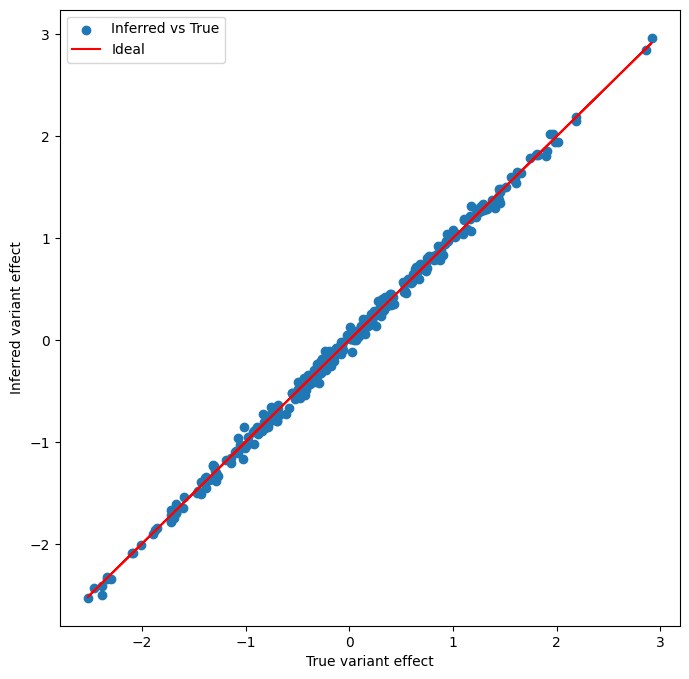

In [54]:
# Make a comparison plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.scatter(known_variant_effects, inferred_variant_effects.mean(axis=(0,1)), label='Inferred vs True')
plt.plot(known_variant_effects, known_variant_effects, color='red', label='Ideal')
plt.xlabel('True variant effect')
plt.ylabel('Inferred variant effect')
plt.legend()
plt.show()

## Compute the r2 value for the known and inferred variant effects

In [55]:
from sklearn.metrics import r2_score
import numpy as np

# Example data
y_true = known_variant_effects
y_pred = inferred_variant_effects.mean(axis=(0,1))

# Calculate R2 score
r2 = r2_score(y_true, y_pred)

print(f'R2 score: {r2}')

R2 score: 0.9973284055574294


# Use the above model that passed the inference check to infer variant effects for the real dataset

## Prepare model for inference by providing the experimental data (library and endpoint counts)

In [56]:
pymc_sge_model = model(
    endpoint_counts.size(), 
    library_freq=None, 
    library_amplitude=None, 
    endpoint_amplitudes=None, 
    library_counts=library_counts, 
    endpoint_counts=endpoint_counts, 
    variant_effect=None
)

## Perform inference of unobserved quantities (library frequencies, library amplitude, endpoint amplitudes, and variant effects)

In [57]:
with pymc_sge_model:
    idata = pm.sample(1000, tune=2000, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [library_freq, library_amplitude, endpoint_amplitudes, variant_effect]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 90 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 811 divergences after tuning. Increase `target_accept` or reparameterize.


## Plot the posterior inferences

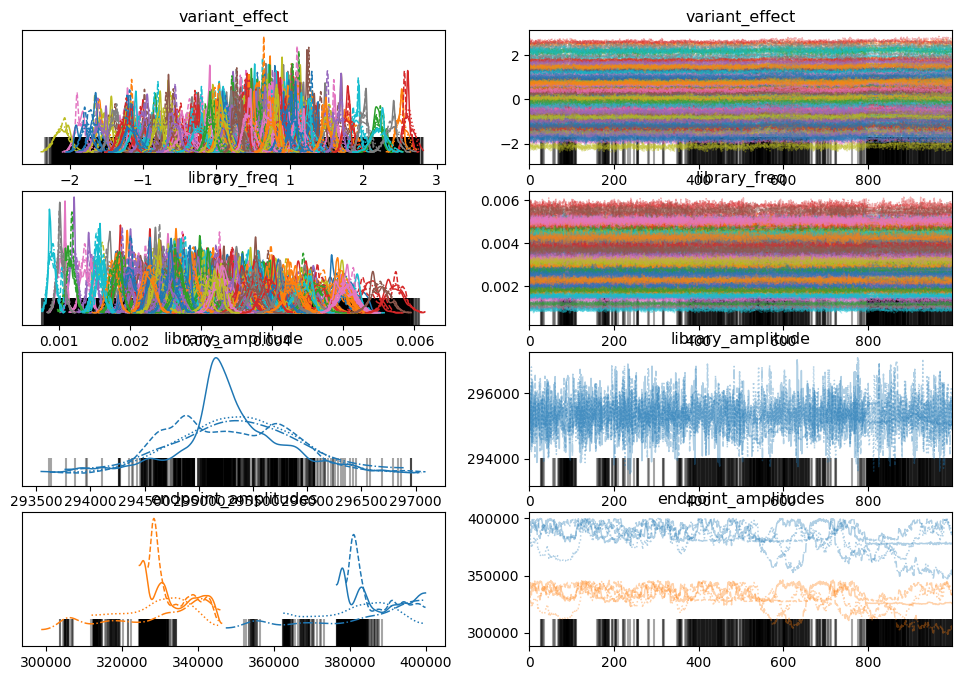

In [58]:
az.plot_trace(idata);

## Perform a posterior predictive check

In [59]:
with pymc_sge_model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng)

Sampling: [endpoint_counts, library_counts]


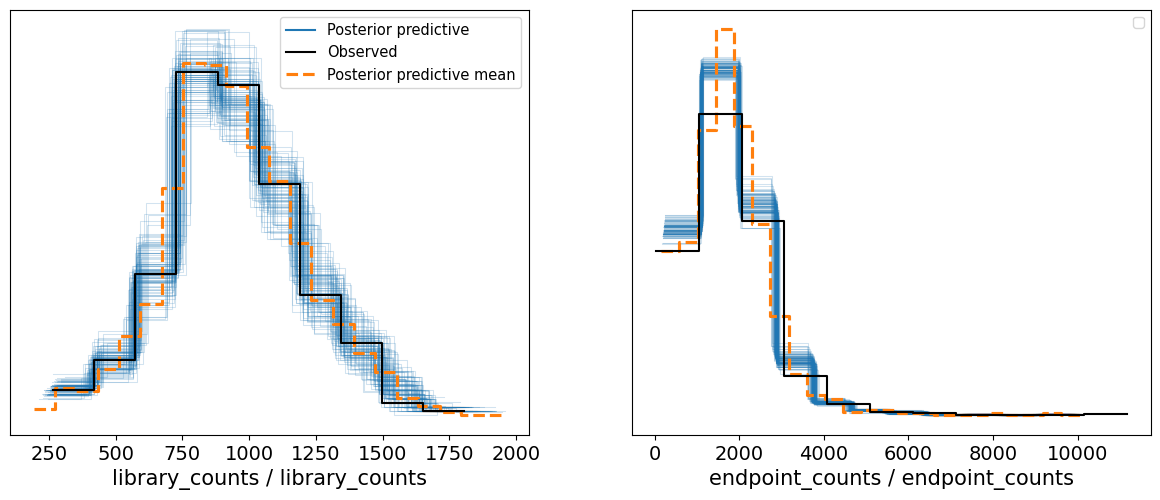

In [60]:
az.plot_ppc(idata, num_pp_samples=100, group='posterior');

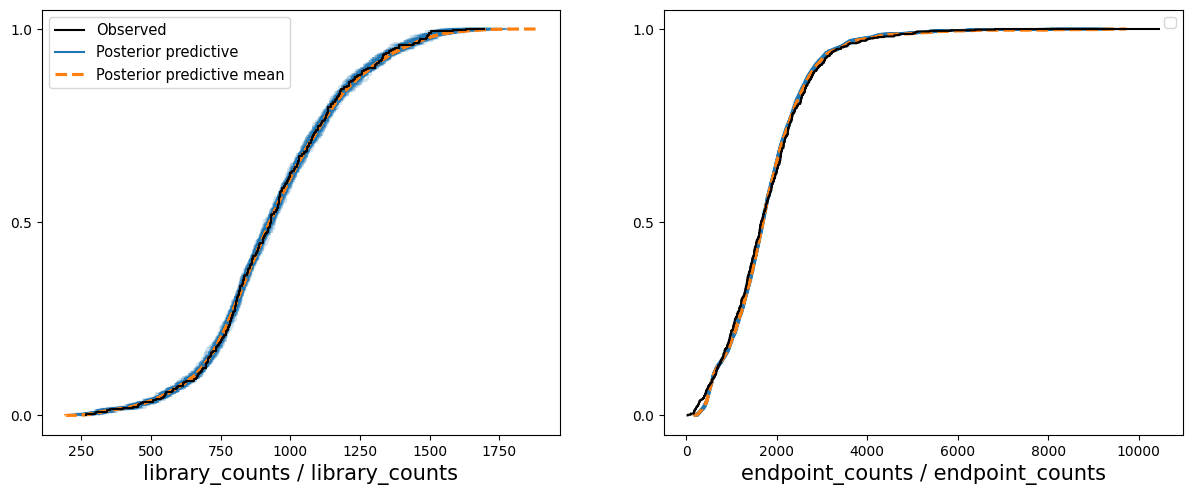

In [61]:
az.plot_ppc(idata, num_pp_samples=100, group='posterior', kind='cumulative');

## Plot a comparison of inferred variant effects and original variant effects

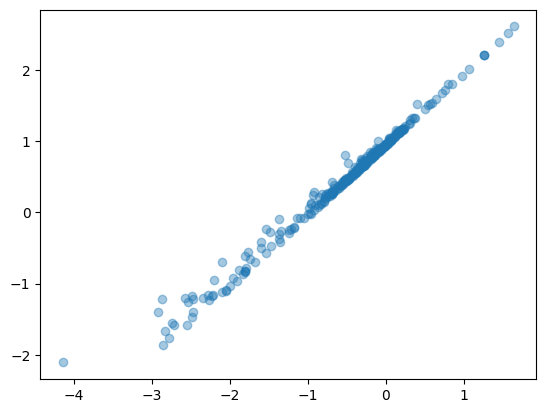

In [64]:
plt.scatter((df['d11/lib.raw.r1']+df['d11/lib.raw.r2'])/2., idata.posterior.get('variant_effect').mean(axis=(0,1)), alpha=0.4)
# plt.errorbar((df['d11/lib.raw.r1']+df['d11/lib.raw.r2'])/2., idata.posterior.get('variant_effect').mean(axis=(0,1)), yerr=3*idata.posterior.get('variant_effect').std(axis=(0,1)), fmt=' ', alpha=0.5, c="red")

<ErrorbarContainer object of 3 artists>

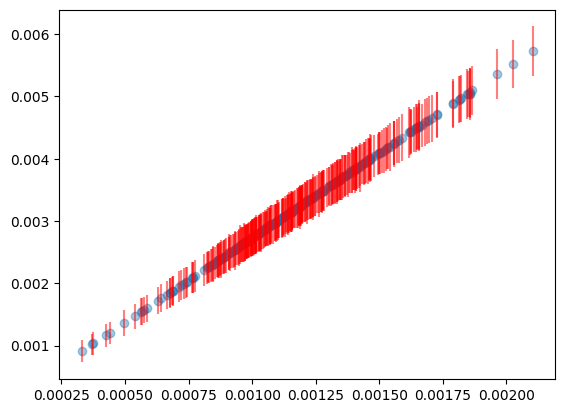

In [65]:
plt.scatter(df['library.freq'], idata.posterior.get('library_freq').mean(axis=(0,1)), alpha=0.4)
plt.errorbar(df['library.freq'], idata.posterior.get('library_freq').mean(axis=(0,1)), yerr=3*idata.posterior.get('library_freq').std(axis=(0,1)), fmt=' ', alpha=0.5, c="red")

## Compute AUROC for original and inferred variant effects

In [66]:
assay_df = df
pathogenic_df = assay_df[assay_df['clinvar_simple'].isin(['Pathogenic', 'Likely pathogenic'])]
pathogenic_scores = np.array(pathogenic_df.apply(lambda x: (x['d11/lib.raw.r1']+x['d11/lib.raw.r2'])/2., axis=1))
num_pathogenic_total = len(pathogenic_scores)
benign_df = assay_df[assay_df['clinvar_simple'].isin(['Benign', 'Likely benign'])]
benign_scores = np.array(benign_df.apply(lambda x: (x['d11/lib.raw.r1']+x['d11/lib.raw.r2'])/2., axis=1))
num_benign_total = len(benign_scores)
num_reference_total = num_pathogenic_total + num_benign_total
all_reference_scores = np.concatenate((pathogenic_scores, benign_scores))

pathogenic_binaries = [1]*len(pathogenic_scores)
benign_binaries = [0]*len(benign_scores)
binaries_list = pathogenic_binaries+benign_binaries

fpr, tpr, thresholds = roc_curve(binaries_list, -1*np.array(all_reference_scores), pos_label=1)
assay_auc = auc(fpr,tpr)
print(f'AUROC: {assay_auc}')

precision, recall, _ = precision_recall_curve(binaries_list, -1*np.array(all_reference_scores), pos_label=1)
# Compute Area Under the Precision-Recall Curve
auprc = auc(recall, precision)
print(f'AUPRC: {auprc}')

# Compute AUBPRC
prior = 0.1
aubprc = (auprc*(1-prior))/(auprc*(1-prior)+(1-auprc)*prior)
print(f'AUBPRC: {aubprc}')

AUROC: 1.0
AUPRC: 1.0
AUBPRC: 1.0


In [67]:
df.loc[:,'varify_inferred_score'] = idata.posterior.get('variant_effect').mean(axis=(0,1))

In [68]:
assay_df = df
pathogenic_df = assay_df[assay_df['clinvar_simple'].isin(['Pathogenic', 'Likely pathogenic'])]
pathogenic_scores = np.array(pathogenic_df['varify_inferred_score'])
num_pathogenic_total = len(pathogenic_scores)
benign_df = assay_df[assay_df['clinvar_simple'].isin(['Benign', 'Likely benign'])]
benign_scores = np.array(benign_df['varify_inferred_score'])
num_benign_total = len(benign_scores)
num_reference_total = num_pathogenic_total + num_benign_total
all_reference_scores = np.concatenate((pathogenic_scores, benign_scores))

pathogenic_binaries = [1]*len(pathogenic_scores)
benign_binaries = [0]*len(benign_scores)
binaries_list = pathogenic_binaries+benign_binaries

fpr, tpr, thresholds = roc_curve(binaries_list, -1*np.array(all_reference_scores), pos_label=1)
assay_auc = auc(fpr,tpr)
print(f'AUROC: {assay_auc}')

precision, recall, _ = precision_recall_curve(binaries_list, -1*np.array(all_reference_scores), pos_label=1)
# Compute Area Under the Precision-Recall Curve
auprc = auc(recall, precision)
print(f'AUPRC: {auprc}')

# Compute AUBPRC
prior = 0.1
aubprc = (auprc*(1-prior))/(auprc*(1-prior)+(1-auprc)*prior)
print(f'AUBPRC: {aubprc}')

AUROC: 1.0
AUPRC: 1.0
AUBPRC: 1.0
